# **OPTIMIZING TRAINING SETTING FOR EXPLAINABLE CHEMRPROP MODEL USING LAYER-WISE RELEVANCE PROPAGATION**
\
This is a Notebook that demonstrate how to use lrp_chemprop module to analyse and search for an optimal training setting to derive explainable chemprop regression model. For a detail algorithm, please find in the attached report.

***TABLE OF CONTENTS***

1. Import libraries
2. Data preparation
3. Ground-truth establishment
4. Load Chemprop model
5. Extract components from model
6. LRP_Explainer for the chemprop model
7. Faithfulness analysis
8. Explaination Visualization
9. Correctness Analysis

# **1. Import libraries**
\
First, we need to import several libraries used in the analysis. These libraries include data manipulation, data visualization, RDKit, scikit-learn, PyTorch, and Chemprop.


In [25]:
import pandas as pd
import torch
import numpy as np
from pathlib import Path
from lightning import pytorch as pl
from chemprop import data, models
from rdkit import Chem
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
import random
import sys
import os
from skopt import gp_minimize, gbrt_minimize, forest_minimize
from PIL import Image
import io

Additionally, there are five modules that I have established, including: 
- **Model_Extractor**: Extract all information from the models, including both parameters and hidden activations.
- **Data_Preprocessor**: Preprocess data from pandas dataframe to chemprop dataset.
- **LRP_Explainer**: Implement LRP to explain the Chemprop Model's Prediction.
- **Faithfulness_Analyzer**: Implement faithfulness test for the given LRP implementation and the model.
- **Correctness_Analyzer**: Implement correctness test for the givev LRP explanations and Ground-truth explanations.


In [ ]:
sys.path.append(os.path.abspath('../lrp_chemprop/'))
from Model_Extractor import model_extractor
from LRP_Explainer import LRP_Explainer
from Data_Preprocessor import Data_Preprocessor
from Faithfulness_Analyzer import Faithfulness_Analyzer
from Correctness_Analyzer import Correctness_Analyzer

# **2. Data preparation**

To import the data and turn them into Chemprop Dataset, Chemprop DataLoader and Chemprop BatchMolGraph (bmg).

In [26]:
# Read the data, there are only 1 required columns, which is "smiles"
path = 'COX2/diverse_dataset/'
df_total = pd.read_csv(path+'COX2_diverse_data.csv')
split = '_random'
df_train = df_total[df_total['split'+str(split)]=='train']
df_val = df_total[df_total['split'+str(split)]=='val']
df_test = df_total[df_total['split'+str(split)]=='test'].sort_values('docking_score',ascending=True)

In this section, we will prepare our dataset using specific functions. For the sake of explanation, we do not need to prepare data for training, validation, and testing sets. A single set of compounds is sufficient, and it will be used to generate the bmg.

For more details, check: https://github.com/DinhLongHuynh/lrp_chemprop/blob/main/lrp_chemprop/Data_Preprocessor.py

In [ ]:
# Initilized Data_Preprocessor
data_generator = Data_Preprocessor()

# Config
addH = False
HB = True

train_dataset = data_generator.generate(df=df_train,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB=HB)
train_loader = data.build_dataloader(train_dataset, shuffle=False)


val_dataset = data_generator.generate(df=df_val,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
val_loader = data.build_dataloader(val_dataset, shuffle=False)



test_dataset = data_generator.generate(df=df_test,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
test_loader = data.build_dataloader(test_dataset, batch_size=df_test.shape[0], shuffle=False)
batch = next(iter(test_loader))
bmg, V_d, X_d, Y, *_ = batch

# **3. Ground-truth establishment**
This part outlines the ground-truth explanations that will be used for correctness analysis later on. In the context of my research, the ground-truth represents the atom-wise contributions of ligands to the docking score. The first seed mentioned is the ground truth for the COX2 testing set, while the second seed is the ground truth for the CDK2 testing set.

In [6]:
# Ground-truth explanations for COX2 inhibitors
def ground_truth_establish():
        ground_truth = {}
        ground_truth['Compound 0']= torch.tensor([-6,-0.3,-3,-3,-0.3,-0.4,-0.35,0,-0.6,-0.6,-0.6,-0.2,-0.5,-0.5,-0.5,-0.8,-0.6,-0.1,-0.3,-0.1,-0.1,-0.1,-0.3,-0.3,-0.6,-0.4,-0.35,-0.4])
        ground_truth['Compound 1']= torch.tensor([-3,-0.4,-3,-3,-0.4,-0.4,-0.45,-0.1,-0.7,-0.7,-0.7,0,-0.8,0,-0.7,-0.7,-0.1,-0.3,-0.2,-0.4,-0.5,-0.2,-0.3,-0.3,-0.45,-0.4])
        ground_truth['Compound 2']= torch.tensor([-0.5,-0.2,-0.1,-0.25,-0.2,-0.7,-0.6,-0.1,-0.3,-0.4,-0.3,-0.4,-3,-3,-3,-0.4,-0.3,-0.4,-0.3,-0.8,-0.5,-0.7,-0.5,-0.25,-0.1])
        ground_truth['Compound 3']= torch.tensor([-0.5,0,-0.5,0,-0.1,-0.3,-0.1,-0.6,-0.8,-0.6,-0.2,-0.5,-0.5,-0.5,-0.6,-0.6,0,-0.35,-0.4,-0.3,-0.3,-3,-3,-3,-0.4,-0.35,-0.3,-0.1])
        ground_truth['Compound 4']= torch.tensor([-0.4,-0.2,-0.3,-0.2,-0.2,-0.2,-0.6,-0.8,-0.6,-0.2,-0.5,-0.5,-0.5,-0.6,-0.6,0,-0.4,-0.4,-0.3,-0.3,-3,-3,-3,-0.4,-0.4,-0.1])
        ground_truth['Compound 5']= torch.tensor([-0.5,-0.2,-0.1,-0.3,-0.2,-0.7,-0.6,-0.1,-0.4,-0.4,-0.3,-0.3,-0.1,-3,-3,-0.4,-0.4,-0.9,-0.8,-0.8,-0.5,-0.7,-0.5,-0.3,-0.1])
        ground_truth['Compound 6']= torch.tensor([-0.5,0,0,-0.15,-0.35,-0.1,-0.6,-0.8,-0.6,-0.2,-0.5,-0.5,-0.5,-0.6,-0.6,0,-0.45,-0.4,-0.3,-0.3,-3,-3,-3,-0.4,-0.45,-0.35,-0.15])
        ground_truth['Compound 7']= torch.tensor([-3,0.3,-3,-3,-0.3,-0.4,-0.4,0,-0.6,-0.6,-0.6,-0.2,-0.5,-0.5,-0.8,-0.6,-0.2,-0.25,-0.05,-0.2,-0.6,-0.05,-0.25,-0.4,-0.4])
        ground_truth['Compound 8']= torch.tensor([-0.5,0,0,-0.2,-0.3,-0.1,-0.7,-0.7,-0.8,-0.5,-0.7,-0.5,-0.8,-0.6,-0.1,-0.35,-0.4,-0.4,-0.4,-3,-3,-3,-0.4,-0.35,-0.3,0,0,-0.5])
        ground_truth['Compound 9']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.4,-0.35,-0.2,-0.7,-0.9,-0.5,-0.5,-0.7,-0.7,-0.2,-0.1,-0.35,-0.15,-0.35,-0.35,-0.15,-0.35,0,-0.5,0,-0.35,-0.4])
        ground_truth['Compound 10']= torch.tensor([-6,-0.3,-3,-3,-0.3,-0.4,-0.35,0,-0.6,-0.6,-0.6,-0.2,-0.5,-0.5,-0.5,-0.8,-0.6,-0.1,-0.4,-0.1,-0.1,-0.6,0,-0.35,-0.4])
        ground_truth['Compound 11']= torch.tensor([-0.4,-0.4,-0.6,-0.6,-0.6,-0.6,-0.1,-0.25,-0.05,-0.1,-0.6,-0.05,-0.25,-0.6,-0.2,-0.4,-0.4,-0.3,-0.4,-0.1,-3,-3,-0.4,-0.4,-0.6])
        ground_truth['Compound 12']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.4,-0.35,-0.2,-0.5,-0.7,-0.6,-0.3,-0.5,-0.5,-0.5,-0.5,-0.5,0,0,-0.05,-0.35,-0.55,-0.55,-0.35,-0.05,-0.5,-0.35,-0.4])
        ground_truth['Compound 13']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.35,-0.4,-0.2,-0.5,-0.7,-0.5,-0.3,-0.5,-0.5,-0.5,-0.5,-0.5,0,0,0,-0.45,-0.4,-0.45,0,-0.5,-0.4,-0.35])
        ground_truth['Compound 14']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.4,-0.35,0,-0.6,-0.6,-0.6,-0.6,-0.5,-0.6,-0.1,-0.3,-0.2,0,0,-0.4,0,-0.5,0,-0.35,-0.4])
        ground_truth['Compound 15']= torch.tensor([-0.7,-0.5,-0.6,-0.6,-0.6,-0.2,-0.2,-0.1,0,-0.6,-0.1,-0.2,-0.6,-0.2,-0.4,-0.4,-0.3,-0.3,-0.1,-3,-3,-0.4,-0.4,-0.6])
        ground_truth['Compound 16']= torch.tensor([-0.5,0,0,-0.4,-0.3,0,-0.3,-0.2,-0.5,-0.4,-0.4,-0.3,-3,-3,-3,-0.4,-0.5,0,-0.2,-0.3,-0.35,-0.5,-0.5,-0.35,-0.3,0,0,0])
        ground_truth['Compound 17']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.35,-0.4,-0.2,-0.5,-0.7,-0.5,-0.3,-0.5,-0.5,-0.5,-0.5,-0.5,0,0,-0.15,-0.35,-0.5,-0.5,-0.35,-0.15,-0.5,-0.4,-0.35])
        ground_truth['Compound 18']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.4,-0.4,0,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.1,-0.2,-0.1,-0.3,-0.1,-0.5,-0.3,-0.4,-0.4])
        ground_truth['Compound 19']= torch.tensor([-0.5,0,0,-0.15,-0.35,0,-0.6,-0.6,-0.1,-0.4,-0.4,-0.3,-0.3,-3,-3,-3,-0.4,-0.4,-0.6,-0.6,-0.6,0,-0.35,-0.15])
        ground_truth['Compound 20']= torch.tensor([-3,-0.3,-3,-3,-0.3,-0.4,-0.4,0,-0.6,-0.6,-0.6,0,-3.5,-3.5,-0.8,-0.6,-0.1,-0.3,-0.1,-0.1,-0.5,0,-0.4,-0.4])
        ground_truth['Compound 21']= torch.tensor([-0.1,-0.3,-3,-3,-0.3,-0.4,-0.45,0,-0.6,-0.6,-0.6,-0.2,-0.5,-0.5,-0.5,-0.6,-0.6,0,-0.2,-0.1,-0.4,0,0,-0.45,-0.4])
        ground_truth['Compound 22']= torch.tensor([-0.5,0,0,-0.2,-0.3,-0.1,0,0,0,0,-0.2,0,0,-0.4,-0.45,-0.4,-0.3,-3,-3,-3,-0.45,-0.4,-0.1,-0.2,-0.5])
        ground_truth['Compound 23']= torch.tensor([-0.1,-0.3,-3,-3,-0.4,-0.4,-0.5,-0.2,0,-0.3,0,0,0,0,0,0,0,0,0,-0.15,-0.25,-0.2,-0.25,-0.15,-0.5,-0.4])
        ground_truth['Compound 24']= torch.tensor([-0.5,0,0,-3,-0.6,-0.6,-0.6,-0.4,-0.4,-0.3,-0.1,-3,-3,-0.5,-0.6,-0.8,-0.9,-0.4,-0.1,-0.25,-0.3,-0.4,-0.5,-0.3,-0.25])
        ground_truth['Compound 25']= torch.tensor([-0.4,-0.4,0,0,0,-0.1,-0.15,-0.3,-0.3,-0.3,-0.15,0,-0.2,-0.5,-0.4,-0.4,-0.3,-3,-3,-3,-0.4,-0.5,-0.4,0])
        ground_truth['Compound 26']= torch.tensor([-3,-0.4,-3,-3,-0.2,-0.35,-0.45,-0.3,0,0,-0.5,-0.8,-1,-1.1,-0.7,-0.8,-0.7,-0.2,-0.1,-0.3,-0.35,-0.4,-0.35,-0.3,-0.45,-0.35])
        ground_truth['Compound 27']= torch.tensor([-0.5,-0.2,-0.3,-0.15,-0.3,-0.6,-0.9,-0.6,0,0,0,0,0,-3,0,0,-0.6,-0.6,0,-0.35,-0.4,-0.1,-0.5,0,0,0,-0.4,-0.35,-0.15,-0.3])
        ground_truth['Compound 28']= torch.tensor([-0.1,-0.4,-3,-3,-0.4,-0.4,-0.45,-0.1,-0.7,-0.7,-0.7,-0.9,-0.7,-0.7,-0.1,-0.25,-0.35,-0.4,-0.6,-0.35,-0.25,-0.45,-0.4])
        ground_truth['Compound 29']= torch.tensor([-6,-0.3,-3,-3,-0.4,-0.4,-0.5,-0.2,-0.2,0,0,0,0,-0.2,-0.2,-0.35,-0.3,-0.35,-0.2,-0.5,-0.4])
        ground_truth['Compound 30']= torch.tensor([-3,0,0,-0.6,-0.6,-0.8,-0.6,-0.3,-0.4,-0.35,0,0,-5,-5,-0.35,-0.4,-0.6,0,-0.4,-0.2,-0.4,-0.2,-0.4,-0.4,-0.4,-0.6,-1,0])
        ground_truth['Compound 31']= torch.tensor([-0.5,0,0,-0.6,-0.4,-0.1,-0.6,-0.1,0,-0.2,0,-3,0,-0.4,-0.3,-0.5,-0.1,-3,-3,-0.3,-0.5,-0.2,-0.1,-0.2,0])
        ground_truth['Compound 32']= torch.tensor([-0.3,0,-0.2,-0.5,0,-0.2,0,-0.2,-0.5,-0.4,-0.2,-0.3,-0.1,-3,-3,-0.4,-0.5,0,0,-0.3,-0.6,-0.7,-0.5,-0.6,-0.3])
        ground_truth['Compound 33']= torch.tensor([-0.4,-0.1,-0.1,-0.4,-0.1,-0.3,0,0,-0.4,-0.4,0,-0.1,0,-5,-5,0,-0.5,-0.4,-0.1])
        ground_truth['Compound 34']= torch.tensor([-0.5,0,0,-0.6,-0.6,0,-3,0,-0.2,0,0,0,0,0,-0.2,-0.3,-0.45,-0.3,-0.3,-0.1,-3,-3,-0.45,-0.3,-0.2,0,0])
        ground_truth['Compound 35']= torch.tensor([-3,-0.4,-3,-3,-0.3,-0.4,-0.45,-0.2,-0.7,-0.6,-0.6,-0.2,-0.3,-0.8,-0.6,-0.4,-0.5,-0.4,-0.6,-0.6,-0.1,-0.2,-0.15,-0.3,-0.5,-0.15,-0.2,-0.45,-0.4])
        ground_truth['Compound 36']= torch.tensor([-0.25,0,-0.25,0,0,0,0,0,0,-0.4,-0.2,-1.2,-1.2,-1.2,-1.7,-1.4,-0.1,-0.3,-0.2,-0.45,-0.4,-0.3,-0.4,-0.1,-3,-3,-0.4,-0.45])
        ground_truth['Compound 37']= torch.tensor([-0.6,-0.4,0,-0.3,0,0,-0.3,-0.2,-0.45,-0.4,-0.4,-0.3,-0.1,-3,-3,-0.4,-0.45,0,-0.3,-0.3,0,0,0])
        ground_truth['Compound 38']= torch.tensor([-0.5,0,0,-0.5,-0.5,-0.2,-0.7,-0.6,-0.2,-0.5,-0.4,-0.4,-0.3,-6,-3,-3,-0.4,-0.5,-0.7,-0.8,-0.7,-0.5,-0.7,-0.5,-0.1,0,0,-0.5])
        ground_truth['Compound 39']= torch.tensor([-0.5,0,0,-0.2,-0.5,-0.4,-0.4,-0.2,-0.2,-0.1,0,-3,-3,-0.3,-0.3,-0.2,-0.2])
        ground_truth['Compound 40']= torch.tensor([-0.25,0,-0.25,0,0,0,0,0,0,0,0,0,0,0,-0.2,-0.2,-0.45,-0.4,-0.4,-0.3,-0.1,-3,-3,-0.4,-0.45])
        ground_truth['Compound 41']= torch.tensor([0,0,-0.3,-0.2,0,-3,-3,-0.3,-0.5,-0.3,-0.3,-0.2,0,-0.7,-0.7,-1.2,-1.2,-1,-1.2,-0.7])
        ground_truth['Compound 42']= torch.tensor([-0.1,-0.4,-3,-3,-0.4,-0.45,-0.45,0,0,0,-0.3,-0.3,-0.5,-0.5,-0.5,-0.1,0,-1.2,-1.2,-1.2,-1.1,-1,-1,0,0,0,0,-0.45,-0.45])
        ground_truth['Compound 43']= torch.tensor([0,-3,0,-3,0,0,0,0,0,0,0,0,-0.2,-0.2,-0.2,-0.5,-0.4,-0.4,0])
        ground_truth['Compound 44']= torch.tensor([0,0,0,0,-0.05,-0.45,-0.6,-0.45,-0.05,-0.7,-0.7,-0.5,0,-0.3,-0.3,-0.2,0,-3,-0.5,-0.5,0,-3,-0.7,-0.8,-0.5,0])
        ground_truth['Compound 45']= torch.tensor([0,0,-0.1,-0.4,0,0,0,0,-0.1,-0.15,0,0,0,-0.15,0,0,0,-0.1,-0.2,-0.45,-0.4,0,0,-5,-5,-0.4,-0.45])
        ground_truth['Compound 46']= torch.tensor([-0.1,-0.2,0,0,0,-0.2,-0.2,-0.2,-0.2,-0.2,0,0,-0.5,-0.75,-0.65,-0.75,-1.1,-0.75,-0.75,-0.65,0,-3,-3])
        ground_truth['Compound 47']= torch.tensor([-0.3,-0.3,-0.1,0,-0.3,-0.5,0,0,0,0,0,0,-0.4,-0.3,0,-0.4,-3,-3,-0.1,-0.5,-0.5,-0.5,-0.2])
        ground_truth['Compound 48']= torch.tensor([-0.3,0,-0.3,0,0,0,0,0,0,-0.3,-0.4,0,0,0,-0.2,-0.3,-0.45,-0.45,-0.4,-0.3,-0.1,-3,-3,-0.45,-0.45])
        ground_truth['Compound 49']= torch.tensor([-0.5,0,-0.65,-1.15,-0.95,-0.65,0,0,-0.2,-0.4,-0.35,-0.3,-0.4,-0.1,-3,-3,-0.35,-0.4,-0.85,-0.95,-0.85])
        ground_truth['Compound 50']= torch.tensor([0,0,-0.35,-0.15,-0.1,-0.4,-0.3,-0.3,-0.45,0,-3,-0.3,0,-3,-0.45,-0.15,-0.35])
        ground_truth['Compound 51']= torch.tensor([-0.6,-0.4,-0.2,-0.2,0,0,0,-0.5,-0.5,-0.5,-0.4,-0.2,-0.2,-0.2,-0.3,0,0,-0.4,-3,-3,-0.1,-0.5,-0.5,-0.5,-0.7])
        
        # Append a small values to each atom's contribution to avoid absolute 0, which will cause a number instability problem for correctness analysis 
        for compound in ground_truth.keys():
            ground_truth[compound]= ground_truth[compound]-1e-10
    
        return ground_truth

ground_truth = ground_truth_establish()

In [6]:
# Ground-truth explanations for CDK2 inhibitors
def ground_truth_establish():
    ground_truth = {}
    ground_truth['Compound 0']= torch.tensor([-0.1,0,-7,0,-0.4,-0.5,-0.3,-0.2,0,0,0,-3,0,-0.4,-0.1,-0.1,0,0,0,0,-7,0,0,0,0,0,-3,-3,0,-3,0,-0.4,-0.5,-0.3,0,0,0,-0.1,-0.1])
    ground_truth['Compound 1']= torch.tensor([-10,0,-0.2,0,0,0,0,0,-3,0,-0.2,0,0,0,0,-3,0,-0.35,-0.15,0,-0.15,-0.35,-3,0,-0.2,-0.7,-0.5])
    ground_truth['Compound 2']= torch.tensor([0,0,-7,0,-0.3,-0.5,-0.3,-0.2,0,0,0,-3,0,-0.2,-0.1,-0.1,0,0,-0.2,0,0,0,0,0,0,0,0,0,-0.13,-0.13,-0.13,0,-3,0,-0.4,-0.5,-0.2,0,0,0,-0.2,-0.2])
    ground_truth['Compound 3']= torch.tensor([0,0,0,0,-3,0,-0.05,-0.1,0,0,0,0,0,-0.2,0,-3,0,-3,0,-0.2,-0.6,-0.6,-0.2,-0.3,0,-0.3,0,0,0,-0.1,-0.05])
    ground_truth['Compound 4']= torch.tensor([-10,0,0,0,0,0,-0.3,-0.5,0,-0.3,-0.3,0,-3,-0.5,-0.3,0,-0.9,-0.8,-0.1,-0.5,-0.3,-3,0,-3])
    ground_truth['Compound 5']= torch.tensor([-0.2,-0.1,-0.1,0,0,0,0,-0.2,0,-0.3,-0.1,0,-7,0,0,-0.1,-0.1,0,0,0,0,-0.3,-0.5,-0.4,-0.3,-0.3,0,-0.4,0,-3,0,0,-3])
    ground_truth['Compound 6']= torch.tensor([-6,0,0,0,0,0,0,0,-3,0,-0.2,0,0,0,0,-3,0,-0.35,-0.15,0,-0.15,-0.35,-3,0,-0.2,-0.6,-0.5])
    ground_truth['Compound 7']= torch.tensor([-0.2,-0.2,0,-7,0,-0.1,-0.1,0,0,0,-0.1,-3,0,-3,0,-0.4,0,0,-0.2,-0.4,-0.3,-0.3,0,-0.2,0,0,0])
    ground_truth['Compound 8']= torch.tensor([0,-7,0,0,0,0,0,-7,0,0,-0.05,-0.15,0,0,0,0,0,-0.2,0,-3,0,-3,0,-0.2,-0.6,-0.6,-0.3,-0.3,0,0,0,-0.15,-0.05])
    ground_truth['Compound 9']= torch.tensor([-0.2,0,-3,0,0,0,0,0,-0.2,-0.3,0,-0.3,-0.2,0,-3,-0.4,-0.3,0,-0.9,-0.7,-0.1,-0.5,-0.2,-3,0,-3])
    ground_truth['Compound 10']= torch.tensor([-0.1,0,0,0,0,0,0,0,-3,0,-0.25,-0.05,0,0,-3,0,-0.05,-0.25,-3,0,-0.4,-0.5,0,0,-0.2,-0.2])
    ground_truth['Compound 11']= torch.tensor([-0.3,0,0,0,0,0,0,0,-3,0,-0.3,-0.1,0,0,-3,0,0,-0.5,0,-3,0,-0.4,-0.5,0,0,-0.2,-0.2])
    ground_truth['Compound 12']= torch.tensor([0,0,0,0,-3,0,-0.1,-0.2,-0.2,-0.2,0,0,0,0,-0.2,0,-3,0,-3,0,-0.2,-0.6,-0.5,-0.2,-0.3,0,0,0,-0.1])
    ground_truth['Compound 13']= torch.tensor([-0.3,0,0,0,0,0,-0.3,0,-3,0,-3,0,-0.4,-0.15,0,-0.2,0,-1.5,-1.5,-0.15,-0.4,0,0,0,-0.75,-0.75])
    ground_truth['Compound 14']= torch.tensor([0,0,0,0,0,-3,0,-0.2,0,0,0,0,-3,0,-0.35,-0.1,0,-0.1,-0.5,-0.5,-0.5,-0.1,-0.35,-3,0,-0.2,-0.6,-0.6])
    ground_truth['Compound 15']= torch.tensor([0,0,0,-0.2,0,-3,0,-0.2,0,0,0,0,-3,0,-0.35,0,0,-0.3,-0.2,-1.5,-1.5,0,-0.35,-3,0,-0.2,-0.6,-0.6])
    ground_truth['Compound 16']= torch.tensor([-0.2,0,-3,0,-0.4,0,0,0,0,-3,0,-0.35,-0.05,0,-0.3,0,-3,-0.05,-0.35,-3,0,-0.2,-0.9])
    ground_truth['Compound 17']= torch.tensor([-0.35,-0.1,-0.35,0,-3,0,0,-0.3,-0.4,0,-0.3,0,0,0,-3,0,-0.2,-0.7,-0.6,-0.3,])
    ground_truth['Compound 18']= torch.tensor([-0.2,0,-3,0,-0.4,0,0,0,0,-3,0,-0.3,-0.05,0,-0.3,-3,-3,-0.05,-0.3,-3,0,-0.2,-0.9])
    ground_truth['Compound 19']= torch.tensor([-0.3,-0.6,-0.6,-0.6,-0.6,0,-0.4,0,-3,0,-3,0,-0.15,-0.05,0,-7,0,0,-0.05,-0.15,0,-0.6,0,-0.25,-0.25])
    ground_truth['Compound 20']= torch.tensor([-0.3,0,0,0,0,0,-3,0,-0.4,-0.15,0,-0.1,0,-3,0,0,-3,-0.15,-0.4,-3,0,-0.2,-0.9,0,-0.2,-0.2,-3])
    ground_truth['Compound 21']= torch.tensor([0,0,-0.4,0,-3,0,-3,0,-0.3,-0.5,0,0,0,0,0,-0.2,0,0,-0.2,-0.2,0,-0.2,-0.2,-0.1,0,-3,0,0,0])
    ground_truth['Compound 22']= torch.tensor([-0.5,-0.6,-0.5,-0.5,-0.2,0,-3,0,-3,0,-0.1,-0.1,0,-1,0,0,0,-0.3,0,0,0,-0.1,0,0,0,0,0,0,0,0,-0.2])
    ground_truth['Compound 23']= torch.tensor([0,0,0,0,0,0,0,0,0,-0.4,-0.1,0,-7,0,0,-0.2,-0.2,0,0,0,0,-0.2,-0.3,-0.1,-0.2,-0.3,0,-0.4,0,-3,0,0,-3])
    ground_truth['Compound 24']= torch.tensor([-0.5,-0.6,-0.5,-0.5,-0.2,0,-3,0,-3,0,-0.1,-0.1,0,-7,0,0,0,-0.3,0,0,0,-0.1,0,0,0,0,0,0,0,-0.1,-0.3])
    ground_truth['Compound 25']= torch.tensor([-0.1,0,0,0,0,-0.3,-0.7,-0.6,-0.3,-0.2,-0.3,0,-0.3,0,0,-3,0,-0.1,-0.33,-0.33,-0.33])
    ground_truth['Compound 26']= torch.tensor([-3,0,-0.5,-0.3,-0.2,-0.2,0,-0.4,0,-3,-3,0,-0.3,-0.5,-0.5,-0.5,0,0,0,-0.1,0,0,0,0,-0.1,-0.1,-0.5])
    ground_truth['Compound 27']= torch.tensor([0,0,-3,0,-0.2,-0.2,0,-0.1,-0.1,-0.2,-0.3,-0.5,-0.2,0,0,0,0,0,-3,0,0,0,0,-3,0,-0.25,-0.05,0,-0.5,-0.05,-0.25,-0.1,-0.5,0,-3])
    ground_truth['Compound 28']= torch.tensor([0,-7,0,0,-0.1,0,0,0,-0.1,0,0,0,-0.05,-0.3,0,-3,0,-3,0,-0.4,0,0,0,0,0,-0.2,0,0,0,0,0,-0.3,-0.05])
    ground_truth['Compound 29']= torch.tensor([0,0,-0.4,-0.5,-0.7,-0.2,0,-3,0,-3,0,-0.4,-0.15,0,0,0,0,-4,0,0,-0.15,-0.4,0,0,0,0,-0.3,0,0,-0.3])
    ground_truth['Compound 30']= torch.tensor([0,-3,0,0,0,-0.1,-0.1,-0.3,0,-3,0,-3,0,-0.4,0,0,0,0,0,-0.2,-0.1,0,0,0,0,-0.3,-0.1])
    ground_truth['Compound 31']= torch.tensor([-3,0,-3,0,-0.9,-0.4,-0.3,-0.5,-0.3,0,0,0,0,-3,-0.3,-0.4,0,-0.3,-0.2,0,-3,-0.4,-0.3])
    ground_truth['Compound 32']= torch.tensor([-0.7,-0.4,-0.7,-0.2,0,-3,0,-3,0,-0.35,-0.15,0,0,0,0,0,0,0,-0.15,-0.35,0,0,0,0,-0.3,0,0,-0.3,0,0])
    ground_truth['Compound 33']= torch.tensor([-0.1,0,0,0,0,-0.1,0,0,0,0,-0.4,0,-3,-3,0,-0.1,-0.5,-0.5,-0.5,-0.3,-0.2,-0.1,-0.1,-0.3,-0.7,-0.3,-0.9,-3,-0.2])
    ground_truth['Compound 34']= torch.tensor([0,0,0,-0.1,-0.15,-0.2,0,-0.2,-0.15,0,0,-3,-3,0,-0.5,-0.6,0,0,0,-0.6,-0.3,-0.3,0,0,-0.4,-0.4])
    ground_truth['Compound 35']= torch.tensor([0,0,0,0,-0.25,-0.25,-0.1,0,0,0,-3,0,-3,-3,0,-0.5,-0.1,0,0,0,0,0,-0.1,0,0,-0.3,-0.4,-0.25,-0.25])
    ground_truth['Compound 36']= torch.tensor([-0.6,0,0,0,-0.2,0,0,0,0,0,0,-0.4,0,-3,0,-3,0,-0.4,-0.15,-0.1,0,-6,0,0,-0.15,-0.4,0])
    ground_truth['Compound 37']= torch.tensor([-0.1,0,0,0,0,0,0,-3,0,-0.1,-0.1,-0.2,-0.2,-0.3,-0.5,-0.4,0,-3,0,0,0,-0.6,-0.6,0,0,0,-0.1,-3])
    ground_truth['Compound 38']= torch.tensor([0,-0.2,0,0,0,0,0,-3,0,0,-0.2,-0.2,0,-0.1,-4,0,0,-3,0,0,0,-0.6,-0.6,0,0,0,-0.4,-3])
    ground_truth['Compound 39']= torch.tensor([0,-3,-0.2,-1.5,-1.5,0,-0.1,-0.25,0,-3,0,-3,0,-0.4,0,0,0,0,0,-0.2,0,0,0,0,0,-0.2,-0.1])
    ground_truth['Compound 40']= torch.tensor([0,0,0,-0.05,-0.15,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.1,-0.6,0,-0.15,-0.05])
    ground_truth['Compound 41']= torch.tensor([0,0,0,0,0,-0.1,-0.2,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.1,-0.6,0,-0.3])
    ground_truth['Compound 42']= torch.tensor([0,0,0,-0.1,0,0,0,-0.3,-0.5,0,-3,-3,0,-0.9,-0.7,-0.1,-0.5,-0.3,-0.3,-0.3,0,0,0,-3,0,0,0,-0.3])
    ground_truth['Compound 43']= torch.tensor([-1.3,-1.3,-1.3,0,-0.05,-0.2,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.1,-0.6,0,-0.2,-0.05])
    ground_truth['Compound 44']= torch.tensor([-0.1,-0.1,0,0,0,0,0,-3,0,0,-0.15,0,0,0,-0.15,0,-3,0,0,0,-0.65,-0.65,0,0,0,-0.2,-3])
    ground_truth['Compound 45']= torch.tensor([0,-0.1,0,0,0,-0.05,-0.3,0,-3,0,-3,0,-0.4,0,0,0,0,0,-0.2,0,0,0,0,0,-0.3,-0.05])
    ground_truth['Compound 46']= torch.tensor([0,0,0,-0.1,-0.25,-0.25,0,0,-0.25,-0.25,-3,0,-3,-3,0,-0.5,-0.1,0,0,0,0,0,-0.1,0,0,-0.3,-0.4])
    ground_truth['Compound 47']= torch.tensor([0,-0.1,0,-0.1,0,-0.2,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.3,-0.6,0,-0.2])
    ground_truth['Compound 48']= torch.tensor([0,0,0,0,-0.1,-0.2,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.1,-0.6,0,0])
    ground_truth['Compound 49']= torch.tensor([-0.15,0,-0.15,0,-0.05,-0.2,0,-3,0,-3,0,-0.4,0,-0.9,-0.6,-0.6,-0.6,0,0,0,-0.3,-0.6,0,-0.2,-0.05])
    ground_truth['Compound 50']= torch.tensor([-0.6,0,0,0,-0.9,-0.6,-0.2,0,0,0,-3,0,-0.2,-0.1,0,0,0,0,0,0,-0.1,-0.3,-0.5,-0.6,0,0,-0.2,-0.25,0,-6,0,0,-0.25])
    ground_truth['Compound 51']= torch.tensor([-3,0,0,0,-0.1,-0.15,-0.35,0,-3,0,-0.5,0,-0.3,-0.3,-0.3,-0.6,0,-3,-0.7,0,-3,-0.35,-0.15])
    ground_truth['Compound 52']= torch.tensor([0,0,-0.6,-0.55,-0.3,0,-0.4,0,-3,0,-0.3,-0.05,0,-0.2,-3,-1.5,-1.5,-0.05,-0.3,-3,-3,-0.55,-0.6])
    ground_truth['Compound 53']= torch.tensor([-0.6,0,-0.6,0,0,-3,0,0,-3,0,0,-0.1,0,-0.2,-0.2,-0.15,-0.1,-0.1,-0.1,-0.15,-0.2,0,0,0,0,-0.1,-0.1,0,-10,-0.1,-0.1,0,0])
    ground_truth['Compound 54']= torch.tensor([0,-0.2,0,0,0,0,0,-3,0,0,-4,0,0,-0.2,-0.2,-0.4,0,-3,0,0,0,-0.65,-0.65,0,0,0,-0.2,-3])
    ground_truth['Compound 55']= torch.tensor([-3,0,-3,0,-0.9,-0.7,-0.1,-0.5,-0.3,-0.3,-0.1,0,0,0,0,0,-0.1,-0.3,0,-0.3,-0.1,0,-3,-0.5,-0.3])
    ground_truth['Compound 56']= torch.tensor([0,0,-3,0,-0.2,-0.1,0,0,0,0,0,-4,0,0,-0.1,-0.2,0,-3,0,0,0,0,0,0,0,0,0,-3,0,-0.1,-0.2])
    ground_truth['Compound 57']= torch.tensor([0,0,0,-0.1,-0.2,-0.2,-0.2,0,0,0,0,-3,0,0,0,0,0,-0.05,-0.1,0,-10,-0.1,-0.05,0,0,0,-3,0,0,0,-0.6,-0.6,0,-0.2])
    ground_truth['Compound 58']= torch.tensor([-0.6,0,-0.6,0,0,-3,0,0,-3,0,0,0,0,-0.2,-0.2,-0.2,-0.1,0,0,-0.5,-0.2,0,0,0,0,0,-0.05,-0.1,0,-10,-0.1,-0.05,0,0])
    ground_truth['Compound 59']= torch.tensor([0,0,0,0,0,-0.1,0,-3,0,-3,0,-0.4,0,-0.8,-0.6,-0.6,-0.6,0,0,0,-0.3,-0.6,0,-0.2])
    ground_truth['Compound 60']= torch.tensor([0,0,0,0,0,0,-0.2,-0.2,-0.2,-0.4,-0.1,0,-3,0,0,0,0,0,-0.05,-0.1,0,-10,-0.1,-0.05,0,0,0,-3,0,0,0,-0.6,-0.6,0,-0.2])
    ground_truth['Compound 61']= torch.tensor([0,0,0,0,-0.3,-0.4,-0.9,0,-0.3,-0.3,-0.5,0,-3,0,-0.2,-0.15,0,-0.1,0,0,0,-0.15,-0.2,0,-3,-3])
    ground_truth['Compound 62']= torch.tensor([0,0,0,0,0,0,0,-0.1,-0.2,0,-3,0,0,0,-3,-3,0,0,0,0,0,0,0,0,0,-0.1,-0.1,-0.2,-0.2,-0.1,0,0])
    ground_truth['Compound 63']= torch.tensor([0,0,0,0,0,0,0,0,-3,0,0,0,-3,0,0,0,0,0,0,-2,-2,-2,0,0,0,0])
    ground_truth['Compound 64']= torch.tensor([-0.5,-0.3,-0.5,-0.5,0,-3,-3,0,-0.4,0,0,0,0,-0.1,0,0,0,0,-0.1,-0.1,-0.2,-0.2,0,0,0,-0.3])
    ground_truth['Compound 65']= torch.tensor([-0.1,-0.1,-0.1,0,-0.1,-0.1,-0.4,0,-0.3,-0.2,0,-3,-0.4,-0.5,0,-0.7,-0.4,-0.1,-0.5,-0.4,-3,0,-3])
    ground_truth['Compound 66']= torch.tensor([0,0,0,-0.3,-0.3,0,-3,0,0,-3,-0.2,-0.1,0,-0.2,0,-0.2,0,-7,0,0,0,0,0])
    ground_truth['Compound 67']= torch.tensor([-0.3,-0.3,0,0,-2,-2,-0.4,-0.7,0,-0.4,-0.4,0,-3,0,-0.3,-0.2,-0.2,-0.1,0,0,0,-0.2,-0.3,0,-3,-3])
    ground_truth['Compound 68']= torch.tensor([0,0,0,0,-0.1,-0.2,0,0,0,0,0,-3,0,0,0,-3,0,-0.2,-0.05,0,0,0,0,0,0,0,0,0,-0.05,-0.2,-0.1,0,0,0,-0.2])
    ground_truth['Compound 69']= torch.tensor([-3,0,-0.3,0,0,0,-0.1,0,-4,0,0,0,-0.2,-0.3,-0.8,-0.9,0,-0.2,0,-3,0])
    ground_truth['Compound 70']= torch.tensor([0,0,0,-0.4,0,-3,0,-3,0,-0.2,-0.7,0,0,0,-0.3,0,-0.1,0,-0.1,-0.2,0,-0.2,0,-4])
    ground_truth['Compound 71']= torch.tensor([-0.2,0,0,-0.1,0,-0.3,0,0,0,0,0,-3,0,-0.1,0,0,-4,0,-3,0,-0.2,-0.6])
    ground_truth['Compound 72']= torch.tensor([0,0,0,0,0,-3,-3,0,0,0,-3,0,-0.25,-0.05,0,0,-0.05,-0.25,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1])
    ground_truth['Compound 73']= torch.tensor([0,-0.1,0,0,0,-0.15,-0.2,0,-3,0,-0.5,0,-3,-3,0,-0.8,-0.4,-0.1,-0.2,0,-3,-0.4,-0.2,-0.15])
    ground_truth['Compound 74']= torch.tensor([0,0,0,-0.05,-0.15,0,-3,0,0,0,-3,0,0,0,0,0,0,-0.1,0,0,0,-0.5,-0.2,-0.2,-0.5,-0.15,-0.05])
    ground_truth['Compound 75']= torch.tensor([-0.3,0,-3,-3,0,-0.4,0,0,0,0,-0.1,0,0,0,0,-0.1,0,0,-0.2,-0.2,-0.2,-0.5,-0.2,-0.2])
    ground_truth['Compound 76']= torch.tensor([-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,-3,0,0,0,-3,0,-0.25,-0.15,-0.1,0,0,0,0,0,0,0,-0.15,-0.25,-0.2,-0.1,0])
    ground_truth['Compound 77']= torch.tensor([0,0,-3,0,-0.25,-0.1,0,0,0,0,0,0,0,0,-0.1,-0.25,0,-3,0,0,0,0,0,0,0,0,0,0,-0.1,-0.1,-0.2])
    ground_truth['Compound 78']= torch.tensor([-3,0,-3,0,0,0,0,0,0,-0.1,-0.1,-0.1,0,0,-0.3,-0.6,-0.8,0,0,-3,0,-0.3])
    ground_truth['Compound 79']= torch.tensor([0,0,0,0,0,0,-0.3,0,-3,0,-3,0,-0.2,-0.4,-0.4,0])
    ground_truth['Compound 80']= torch.tensor([0,0,-0.1,-0.1,0,0,0,0,0,0,-3,-3,-0.3,0,-0.3,0,0,0,0,-0.7,-0.4,0])
    ground_truth['Compound 81']= torch.tensor([-3,0,0,0,-3,0,-0.15,-0.15,-0.2,0,-2,-2,-0.15,-0.15,0,0,0,0,-0.4,-0.6,-0.75,-0.7,-0.75,-0.6,-0.4,-0.6,-3])
    ground_truth['Compound 82']= torch.tensor([0,0,0,0,0,0,-6,-3,0,-0.9,-0.6,-0.3,-0.3,-0.2,-0.3,0,-0.2,0,-0.1,-0.2,-0.2,-0.1,0,0,0])
    ground_truth['Compound 83']= torch.tensor([-0.2,-0.3,0,0,-6,0,0,-0.5,-0.4,0,0,0,0,-0.1,-0.1,-0.2,-0.2,-0.2,-0.2,-0.2,-1.5,-1.5,0,0,0])
    ground_truth['Compound 84']= torch.tensor([0,-0.1,0,-0.1,-0.1,0,-3,0,0,0,0,0,-0.1,-0.15,-0.2,-0.2,-0.2,-0.15,0,0,0,-3,0,-3,-0.4])
    ground_truth['Compound 85']= torch.tensor([0,0,0,0,0,-3,0,0,0,-0.1,0,0,0,0,0,0,-0.2,-0.3,-0.4,-0.4,-0.5,-0.65,-0.65])
    ground_truth['Compound 86']= torch.tensor([0,0,0,-0.05,0,0,0,0,0,0,-0.2,-0.2,-0.1,-0.1,0,0,0,0,0,0,0,0,-0.3,-0.5,-0.4,0,-6,0,0,-0.4,-0.2,0,0,0,0,-0.05])
    ground_truth['Compound 87']= torch.tensor([0,0,0,0,0,-3,0,-0.1,-0.3,-0.1,-0.15,0,0,0,0,-0.15,-0.3,-0.4,-0.4,-0.6,-0.65,-0.65])
    ground_truth['Compound 88']= torch.tensor([-0.3,0,-0.3,0,0,-0.3,-0.5,-0.3,0,-6,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.2,0])
    ground_truth['Compound 89']= torch.tensor([-6,0,0,0,-3,0,-0.05,-0.1,-0.1,-0.1,0,0,0,-0.1,-0.05,0,0,0,0,-0.2,-0.15,-0.35,-0.4,-0.35,-0.15,-0.4,-0.6,-3])
    ground_truth['Compound 90']= torch.tensor([-0.1,-0.1,0,0,0,0,-0.4,-0.1,0,-0.3,-0.15,-0.5,-0.1,0,-0.1,-0.1,-0.15,-0.5,0,0,0,-3,-3,0,-0.4])
    ground_truth['Compound 91']= torch.tensor([-3,0,0,-0.1,-0.1,0,-3,0,0,-3,0,0,0,0,-0.4,-0.3,0,-3,0,0,-0.1,-0.2,0,-0.1])
    ground_truth['Compound 92']= torch.tensor([0,0,0,0,0,0,-0.4,-0.1,0,-0.3,-0.25,-0.5,-0.2,-0.1,0,-0.2,-0.25,-0.5,0,0,0,-3,-3,0,-0.4])
    ground_truth['Compound 93']= torch.tensor([-0.15,0,-0.15,-3,0,0,-0.3,-0.3,-0.2,0,0,0,0,-0.5,0,-3,-3,0,0,0,0,0,0,0,-0.1,-0.2,-0.5,-0.5,-0.5,0,0,0,0,0,-0.1,0,0])
    ground_truth['Compound 94']= torch.tensor([0,0,0,0,0,0,-0.4,-0.1,0,-0.3,-0.2,-0.5,-0.1,-0.1,-0.1,-0.2,-0.5,0,0,0,-3,-3,0,-0.4])
    ground_truth['Compound 95']= torch.tensor([0,0,0,0,-3,0,-0.1,0,0,0,-3,0,0,-3,0,0,0,0,-0.3,-0.3,0,-3,0,0,-0.1,-0.2,0,-0.1])
    ground_truth['Compound 96']= torch.tensor([-1.5,0,-3,-3,0,-1.5,0,0,0,0,-0.1,0,0,0,-0.1])
    ground_truth['Compound 97']= torch.tensor([0,0,0,-0.2,-0.3,0,0,0,-3,0,0,0,0,0,0,-0.1,-0.5,-0.7,-0.7,-0.3,-0.6,-0.5,-0.5,0,-0.4,-0.1])
    ground_truth['Compound 98']= torch.tensor([-3,0,0,-3,0,-0.25,0,0,-0.5,0,-0.25,0,0,0,0,-0.3,-0.3,0,-3,0,0,-0.1,-0.2,0])
    ground_truth['Compound 99']= torch.tensor([-0.1,-0.2,-0.2,-0.15,0,0,0,0,0,0,-3,0,0,0,0,0,0,-0.4,-0.6,-0.7,-0.7,-0.7,-0.6,0,0,-0.15])
    ground_truth['Compound 100']= torch.tensor([-3,0,0,0,-3,0,-0.2,-0.2,-0.1,0,-0.1,0,0,0,0,0,-0.5,-0.6,-0.7,-0.7,-0.7,-0.6,0,0,0])
    ground_truth['Compound 101']= torch.tensor([0,0,0,0,0,0,0,0,-0.1,0,-0.1,-0.1,0,0,0,0,0,-0.1,-0.2,-0.2,-0.3,-0.4,-0.2,0,0,0,-0.2,0,-3,])
    ground_truth['Compound 102']= torch.tensor([0,0,0,0,0,-0.1,0,0,0,-0.1,-0.3,-0.3,-0.3,-0.2,-0.3,0,0,0,0,0,0,0,0,-3,0,-0.2,0,0,0,0,0])
    ground_truth['Compound 103']= torch.tensor([-0.7,-0.5,-0.3,0,-3,0,0,-0.1,-0.2,0,0,0,0,-3,0,-3,0,-0.15,0,0,0,-0.15,0,0])
    
    # Append a small values to each atom's contribution to avoid absolute 0, which will cause a number instability problem for correctness analysis 
    for compound in ground_truth.keys():
            ground_truth[compound]= ground_truth[compound]-1e-10
    
    return ground_truth

ground_truth = ground_truth_establish()

# **4. Load Chemprop Model**

In [ ]:
model = models.MPNN.load_from_checkpoint(path+'hyperparam_optim_7/best_checkpoint.ckpt')
# Turn off Dropout to interpret model
model.message_passing.dropout.p=0
model.predictor.ffn[1][1].p = 0

/Users/lod/miniconda3/envs/chemprop/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_locatio

In [8]:
# Set up trainer
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, 
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


The below sections are optional. If you want to check the model's performance, you can run it.

In [ ]:
result_when_batched = trainer.test(model, train_loader)

In [ ]:
result_when_batched = trainer.test(model, val_loader)

Testing DataLoader 0: 100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.7002751231193542     │
│          test/r2          │    0.4511217474937439     │
│         test/rmse         │    1.0069947242736816     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
result_when_batched = trainer.test(model, test_loader)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.720146894454956     │
│          test/r2          │    0.5474413633346558     │
│         test/rmse         │    1.1088613271713257     │
└───────────────────────────┴───────────────────────────┘

# **5. Extract componets from model**

This is where we use Model_Extractor to extract model's parameters (weight matrix, bias matrix, depth, etc.) and model's hidden activations. For the details, please check https://github.com/DinhLongHuynh/lrp_chemprop/blob/main/lrp_chemprop/Model_Extractor.py


In [ ]:
model_params_cache, activations_cache = model_extractor(model,test_loader)

Below is the code to validate my Model_Extractor. The first code is the extraction of aggregation activations using Chemprop built-in function, the seccond one is the extraction of message passing activation using Model_Extractor then use the forward pass to have aggregation activations.

In [28]:
# Aggregation activation from build-in function
model_agg_activations = activations_cache['agg']
# Aggregation activation from Model_Extractor
extractor_agg_activations = model.message_passing.tau(model.message_passing.W_o(activations_cache['mp']))

# Validate extractor
diff = torch.abs(extractor_agg_activations-model_agg_activations)
validation = torch.nonzero(diff)
if validation.numel() == 0: 
    print('The Model_Extractor is valid')
else: 
    for row, col in validation:
        print(f"Value at ({row.item()}, {col.item()}) are not matched")

The Model_Extractor is valid


# **6. LRP_Explainer for the chemprop model**

This seed demonstrate how to run the LRP_Explainer module. For more details, please check https://github.com/DinhLongHuynh/lrp_chemprop/blob/main/lrp_chemprop/LRP_Explainer.py

In [29]:
lrp_explainer = LRP_Explainer(model=model, # Chemprop Model
                    model_params_cache=model_params_cache, # From Model_Extractor
                    activations_cache=activations_cache, # From Model_Extractor
                    bmg = bmg, # BatchMolGraph from the dataset preparation 
                    epsilon=0.001,
                    alpha_1=1.4,
                    alpha_2=2.0)

relevance_atom_all = lrp_explainer.explain_all()
relevance_atom = lrp_explainer.explain_atom()
relevance_bond = lrp_explainer.explain_bond()

# **7. Faithfulness analysis**

First, we need to initialize the Faithfulness_Analyzer with a few simple parameters. It is recommended to run the `manual_control()` method first, as this method takes the longest time to complete. By doing this, we can avoid having to repeat it for subsequent optimizations.

For more details, please check https://github.com/DinhLongHuynh/lrp_chemprop/blob/main/lrp_chemprop/Faithfulness_Analyzer.py

In [31]:
# Initialize Faithfulness_Analyzer
faithfulness = Faithfulness_Analyzer(model=model,
                                 data_frame = df_test,
                                 addH=addH,HB=HB,
                                 num_drop=30)


In [32]:
# Run manual_control methods
rmse_manual = faithfulness.manual_control()

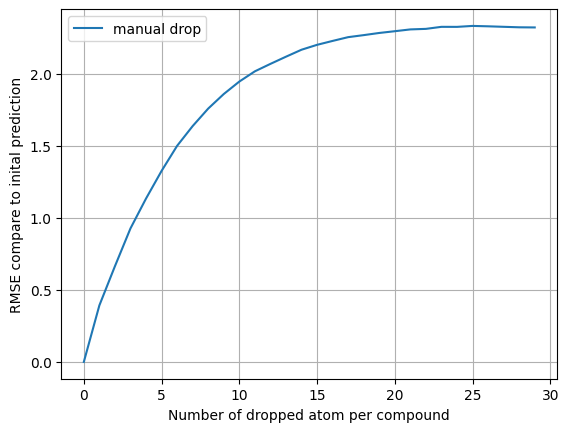

In [15]:
# Plot 
sns.lineplot(rmse_manual, label='manual drop')
plt.xlabel('Number of dropped atom per compound')
plt.ylabel('RMSE compare to inital prediction')
plt.grid()
plt.legend()

The primary objective of faithfulness optimization is to identify the values of alpha (alpha_1 for aggregation layers and alpha_2 for message-passing layers) and epsilon that maximize the faithfulness score. This optimization task is executed using skopt.gp_minimize.

In [17]:
def objective(params):
    alpha_1, epsilon, alpha_2 = params
    score = faithfulness.faithfulness(alpha_1=alpha_1,epsilon=epsilon,alpha_2=alpha_2)
    return -score

# Find the optimal parameters
search_space = [Real(1, 2, name='alpha_1'),Real(1e-6, 1e-1, name='epsilon'),Real(1, 2, name='alpha_2')]
result = gp_minimize(objective, search_space, n_calls=50,random_state=0, verbose = True)
best_alpha_1, best_epsilon, best_alpha_2 = result.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.8655
Function value obtained: -0.5321
Current minimum: -0.5321
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.1604
Function value obtained: -0.5200
Current minimum: -0.5321
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.5518
Function value obtained: -0.5139
Current minimum: -0.5321
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.8869
Function value obtained: -0.5317
Current minimum: -0.5321
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.2486
Function value obtained: -0.5311
Current minimum: -0.5321
Iteration No: 6 started. 

The random drop is a random factor, that needs to run multiple times to estimate the uncertainty of faithfulness score.

In [19]:
i = 0
faithfulness_scores = []
while i<100:
    i+=1
    seed = random.randint(1,10000000)
    score = faithfulness.faithfulness(alpha_1=best_alpha_1, epsilon=best_epsilon, alpha_2=best_alpha_2, seed=seed)
    faithfulness_scores.append(score)
    print(f'{i}th eval: {score}')

1th eval: 0.5378132578475848
2th eval: 0.5489063570537823
3th eval: 0.5136674265117781
4th eval: 0.5358264228224559
5th eval: 0.5452604506459032
6th eval: 0.5125704057182494
7th eval: 0.5178777344684488
8th eval: 0.5263241042216235
9th eval: 0.5198845937560556
10th eval: 0.534626490292866
11th eval: 0.5206976964172115
12th eval: 0.5291302210371068
13th eval: 0.5120954921263576
14th eval: 0.5237797765389166
15th eval: 0.552790453024469
16th eval: 0.5207776567455624
17th eval: 0.47622379604803355
18th eval: 0.5394441273154709
19th eval: 0.5477700978507049
20th eval: 0.556864062067064
21th eval: 0.5392754079971496
22th eval: 0.5458190008777944
23th eval: 0.5024808437543067
24th eval: 0.5246314139039512
25th eval: 0.517071506522228
26th eval: 0.5156782108494957
27th eval: 0.5197365726606977
28th eval: 0.5318844686348931
29th eval: 0.539080026234503
30th eval: 0.5169681762768291
31th eval: 0.5368326627759248
32th eval: 0.508437391764369
33th eval: 0.5234162821182052
34th eval: 0.52778921525

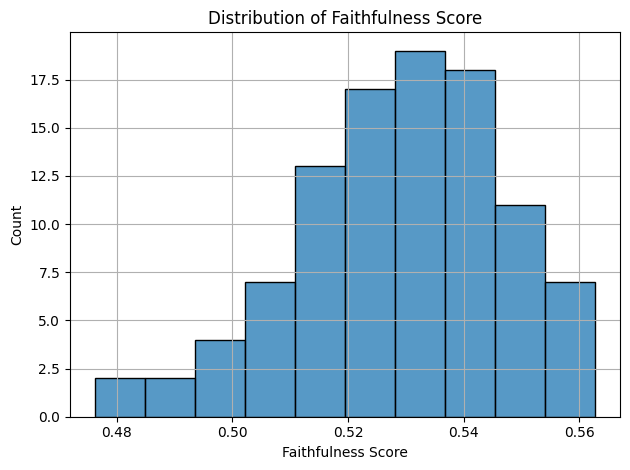

In [22]:
# Plots
sns.histplot(np.array(faithfulness_scores))
plt.title("Distribution of Faithfulness Score")
plt.xlabel('Faithfulness Score')
plt.ylabel("Count")
plt.grid()
plt.tight_layout()


In [25]:
print('Faithfulness Optimiation Result')
print("\t")
print(f'Parameters:')
print(f'alpha_1: {best_alpha_1}')
print(f'epsilon: {best_epsilon}')
print(f'alpha_2: {best_alpha_2}')
print("\t")
print(f'Mean faithfulness score: {np.array(faithfulness_scores).mean()}')
print(f'95% CI Range: {np.quantile(faithfulness_scores,0.05)} - {np.quantile(faithfulness_scores,0.95)}')

Faithfulness Optimiation Result
	
Parameters:
alpha_1: 1.317219634957846
epsilon: 0.04936928526373388
alpha_2: 2.0
	
Mean faithfulness score: 0.5283300752672221
95% CI Range: 0.49400689996804514 - 0.555885172354679


Plot the faithfulness rmse results

In [33]:
rmse_manual, rmse_lrp, rmse_random = faithfulness.analyzer(alpha_1=best_alpha_1, epsilon=best_epsilon, alpha_2=best_alpha_2, seed=0)

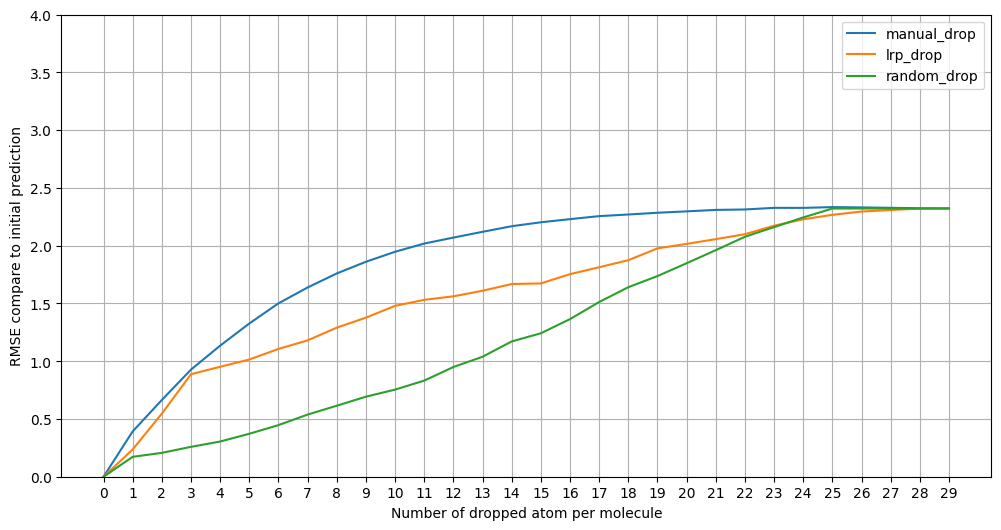

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(0,30),y=rmse_manual,label='manual_drop')
sns.lineplot(x=range(0,30),y=rmse_lrp,label='lrp_drop')
sns.lineplot(x=range(0,30),y=rmse_random,label='random_drop')
plt.xlabel('Number of dropped atom per molecule')
plt.ylabel('RMSE compare to initial prediction')
plt.xticks(range(0,30))
plt.ylim(0,4)
plt.legend()
plt.grid()

# **8. Explanation Visualization**

# **Prepare for visualization**

In [ ]:
# Generate prediction per atom, which is used for normalized relevance score later for visualization purpose
prediction = activations_cache['output_scale'].detach().reshape(-1)
prediction_per_atom = prediction[bmg.batch]

# Run LRP_Explainer with optimal parameters
relevance_atom_agg = LRP_Explainer(model=model,
                                   model_params_cache=model_params_cache,
                                   activations_cache=activations_cache,
                                   bmg = bmg,
                                   alpha_1=best_alpha_1, epsilon=best_epsilon,alpha_2=best_alpha_2).explain_all()


# Normalized relevance socre by its compound predictions
relevance_atom_agg_normalized = relevance_atom_agg/torch.abs(prediction_per_atom)

# Clip the extreme value for better visualization
lower_bound, upper_bound = [-0.15,0.15]
relevance_atom_agg_clipped = np.clip(relevance_atom_agg_normalized.detach().numpy(), lower_bound, upper_bound)


# Standardized relevance socre to the scale 0 and 1
relevance_atom_agg_normalized = (relevance_atom_agg_clipped-upper_bound)/(upper_bound-lower_bound)
relevance_atom_agg_normalized = relevance_atom_agg_normalized.astype(np.float64)

# Determine 0 point on the new scale (0 and 1)
no_contribution_point = (0 - upper_bound)/(upper_bound-lower_bound)

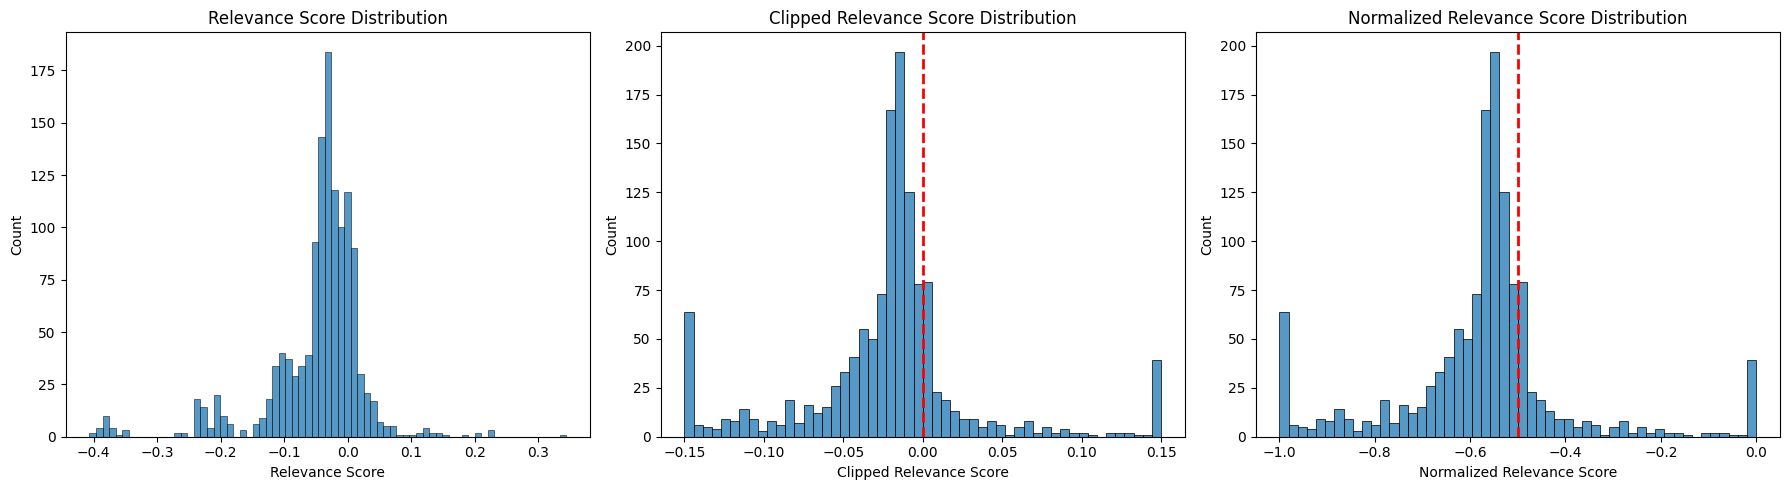

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: Relevance Score Distribution
sns.histplot(relevance_atom_agg.detach(), ax=axes[0])
axes[0].set_title("Relevance Score Distribution")
axes[0].set_xlabel("Relevance Score")

# Plot 2: Clipped Relevance Score Distribution
sns.histplot(relevance_atom_agg_clipped, ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='dashed', linewidth=2)
axes[1].set_title("Clipped Relevance Score Distribution")
axes[1].set_xlabel("Clipped Relevance Score")

# Plot 3: Normalized Relevance Score Distribution
sns.histplot(relevance_atom_agg_normalized, ax=axes[2])
axes[2].axvline(x=no_contribution_point, color='red', linestyle='dashed', linewidth=2)
axes[2].set_title("Normalized Relevance Score Distribution")
axes[2].set_xlabel("Normalized Relevance Score")


plt.tight_layout()
plt.show()


In the next step, we organize the relevance scores into each compound, prepare for visualization.

In [16]:
relevance_atom_normalized_per_comp = {}
for compound_id in range(df_test.shape[0]):
    compound_indice = torch.nonzero(bmg.batch==compound_id,as_tuple=True)[0].tolist()
    atom_relevance_compound = relevance_atom_agg_normalized[compound_indice]
    relevance_atom_normalized_per_comp[f'Compound {compound_id}'] = atom_relevance_compound

In [17]:
relevance_atom_per_comp = {}
for compound_id in range(df_test.shape[0]):
    compound_indice = torch.nonzero(bmg.batch==compound_id,as_tuple=True)[0].tolist()
    atom_relevance_compound = relevance_atom_agg[compound_indice]
    relevance_atom_per_comp[f'Compound {compound_id}'] = atom_relevance_compound

The two seed options listed below perform the same task of organizing relevance scores, but they are specifically designed to handle the add-H cases. If your configuration does not include explicit hydrogen in the molecular graph, use the two seed options mentioned above. If hydrogen is present, use the two seed options listed below.

In [ ]:
relevance_atom_normalized_per_comp = {}
for compound_id in range(df_test.shape[0]):
    compound_indice = torch.nonzero(bmg.batch==compound_id,as_tuple=True)[0].tolist()
    atom_relevance_compound = relevance_atom_agg_normalized[compound_indice]
    relevance_atom_normalized_per_comp[f'Compound {compound_id}'] = atom_relevance_compound

# Aggregate H atoms to relevance atom
for compound_id in range(df_test.shape[0]):
    mol = test_dataset.mols[compound_id]  

    weights = relevance_atom_normalized_per_comp['Compound '+str(compound_id)]

    # Array to store summed weights for heavy atoms
    heavy_atom_summed_weights = torch.zeros(mol.GetNumAtoms())

    num_heavy_atoms = mol.GetNumHeavyAtoms()


    # Single loop through all atoms and neighbors
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() > 1:  # Heavy atom
            atom_idx = atom.GetIdx()
            total_weight = weights[atom_idx]  # Start with heavy atom's weight

            # Directly add weights of attached hydrogens
            total_weight += sum(weights[neighbor.GetIdx()] 
                            for neighbor in atom.GetNeighbors() 
                            if neighbor.GetAtomicNum() == 1)  # Hydrogen check

            # Store result
            heavy_atom_summed_weights[atom_idx] = total_weight
    heavy_atom_summed_weights = heavy_atom_summed_weights[:num_heavy_atoms]
    relevance_atom_normalized_per_comp['Compound '+str(compound_id)] = heavy_atom_summed_weights


In [ ]:
relevance_atom_per_comp = {}
for compound_id in range(df_test.shape[0]):
    compound_indice = torch.nonzero(bmg.batch==compound_id,as_tuple=True)[0].tolist()
    atom_relevance_compound = relevance_atom_agg[compound_indice]
    relevance_atom_per_comp[f'Compound {compound_id}'] = atom_relevance_compound

# Aggregate H atoms to relevance atom
for compound_id in range(df_test.shape[0]):
    mol = test_dataset.mols[compound_id]  

    weights = relevance_atom_per_comp['Compound '+str(compound_id)]

    # Array to store summed weights for heavy atoms
    heavy_atom_summed_weights = torch.zeros(mol.GetNumAtoms(), dtype=weights.dtype)

    num_heavy_atoms = mol.GetNumHeavyAtoms()


    # Single loop through all atoms and neighbors
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() > 1:  # Heavy atom
            atom_idx = atom.GetIdx()
            total_weight = weights[atom_idx]  # Start with heavy atom's weight

            # Directly add weights of attached hydrogens
            total_weight += sum(weights[neighbor.GetIdx()] 
                            for neighbor in atom.GetNeighbors() 
                            if neighbor.GetAtomicNum() == 1)  # Hydrogen check

            # Store result
            heavy_atom_summed_weights[atom_idx] = total_weight
    
    heavy_atom_summed_weights = heavy_atom_summed_weights[:num_heavy_atoms]
    relevance_atom_per_comp['Compound '+str(compound_id)] = heavy_atom_summed_weights


# **Visualization**

Before runing visualization, make sure you have a place to store yours images. In this example, I use the path of ../lrp_visualization

In [164]:
def color_visualization(compound_id, dataset=test_dataset, relevance_score = relevance_atom_normalized_per_comp):
    save_path=f"lrp_visualization/Compound_{compound_id}_color_bmg.png"
    results_comp_atom = relevance_score[f'Compound {compound_id}']

    # SMILES and weights
    smiles = dataset.data[compound_id].name
    atom_weights = results_comp_atom

    # Generate the molecule
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)

    color_map_atom = {}
    for i, weight in enumerate(atom_weights):
        if weight < no_contribution_point:
            alpha = abs(weight - no_contribution_point)  
            color_map_atom[i] = (1, 0.0, 0, alpha*2)  
        else:
            alpha = abs(weight - no_contribution_point)
            color_map_atom[i] = (0, 0.0, 1, alpha*2)



    # Drawing options
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    drawer.DrawMolecule(mol, highlightAtoms=list(range(len(atom_weights))), highlightAtomColors=color_map_atom,highlightBonds=None)
    drawer.FinishDrawing()

    # Convert RDKit Cairo output to a Pillow image
    img_data = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(img_data))

    # Save image with Pillow
    img.save(save_path)

    # Display image using matplotlib
    img = plt.imread(save_path)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)
    ax.axis('off')  # Hide axes

    #Display text info
    text_info = (
        f"Compound {compound_id}\n"
        f"y_true: {dataset.Y[compound_id].item():.2f}\n"
        f"y_predict: {activations_cache['output_unscale'][compound_id].item():.2f}\n"
        f"Residual: {(dataset.Y[compound_id].item() - activations_cache['output_unscale'][compound_id].item()):.2f}"
    )
    ax.text(0.1, 0.5, text_info, fontsize=15, va='center', wrap=True)

    plt.tight_layout()
    plt.show()

def score_visualization(compound_id, relevance_score=relevance_atom_per_comp):
    smiles = df_test.iloc[compound_id,1]
    mol = Chem.MolFromSmiles(smiles)
    atom_weights = relevance_score['Compound '+str(compound_id)]
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp("atomLabel", f'{atom_weights[i]:.2f}')  
    
    img = Draw.MolToImage(mol)
    img.save(f'lrp_visualization/Compound_{compound_id}_score_bmg.png') 



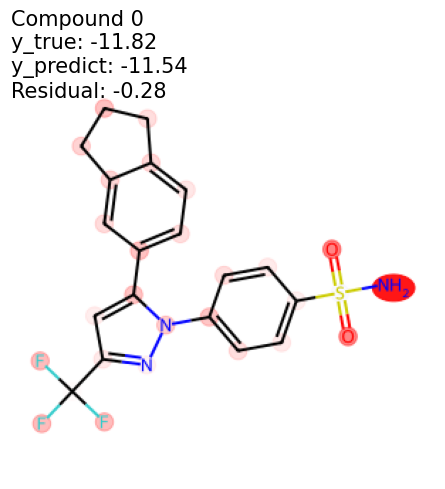

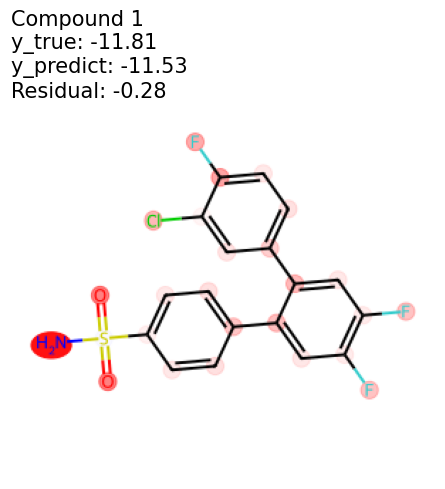

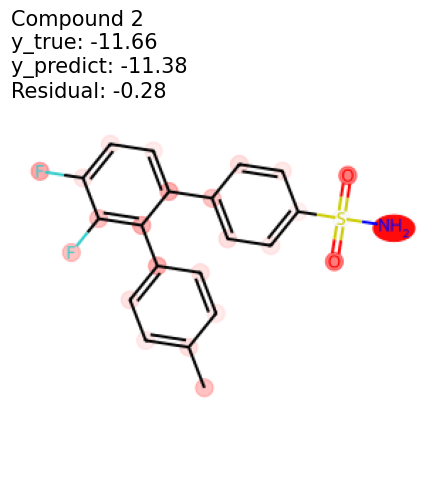

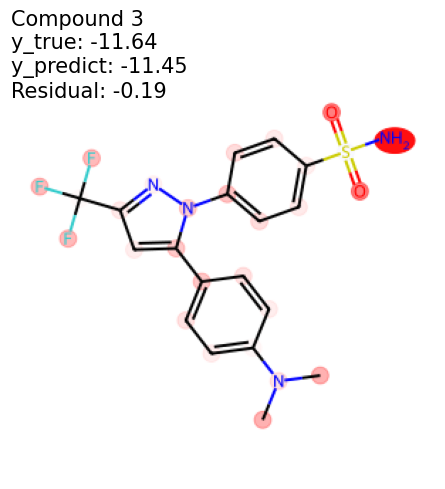

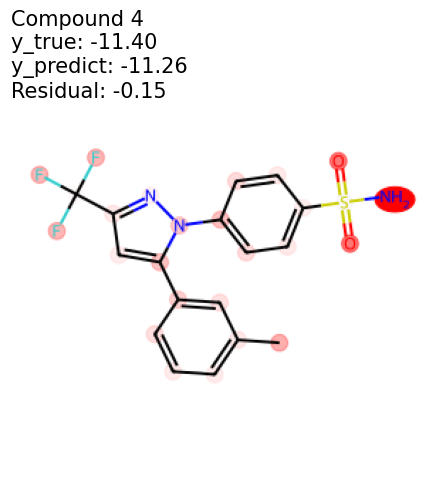

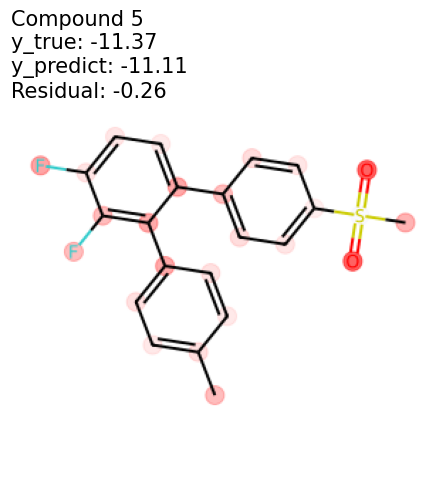

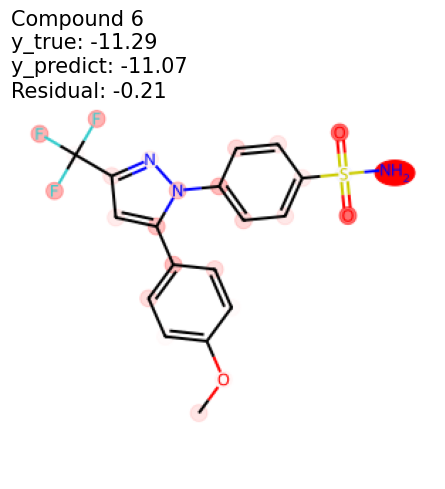

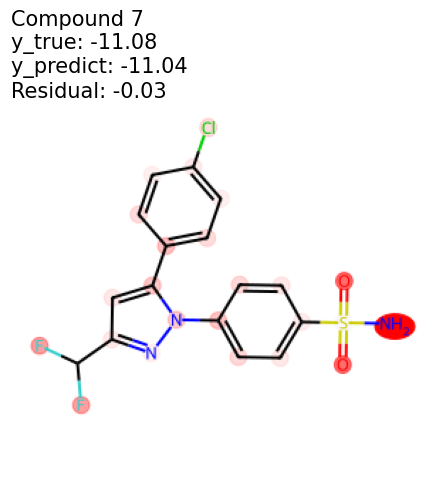

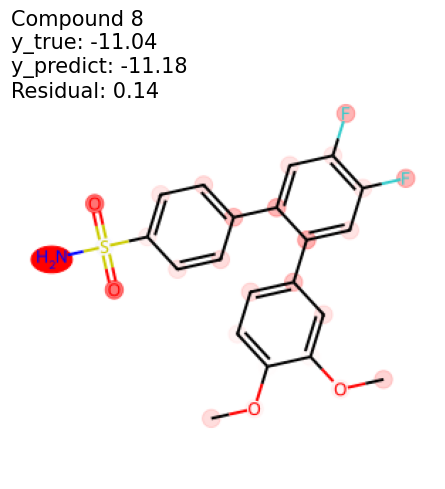

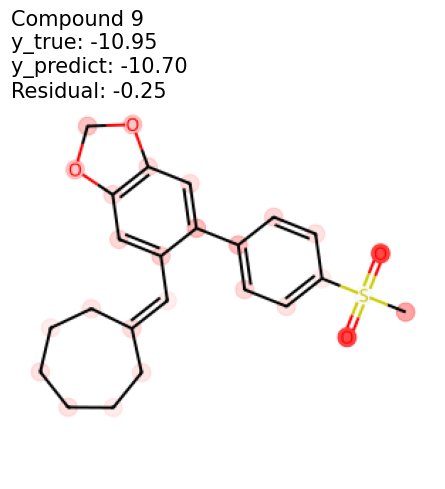

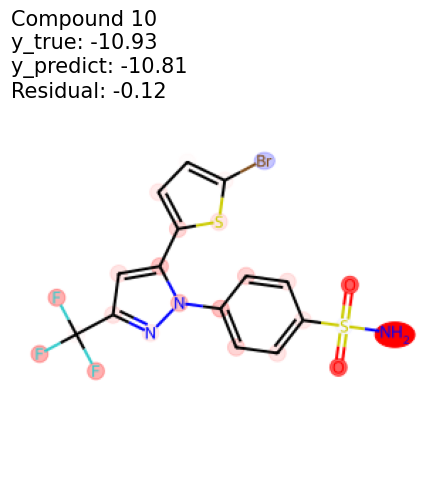

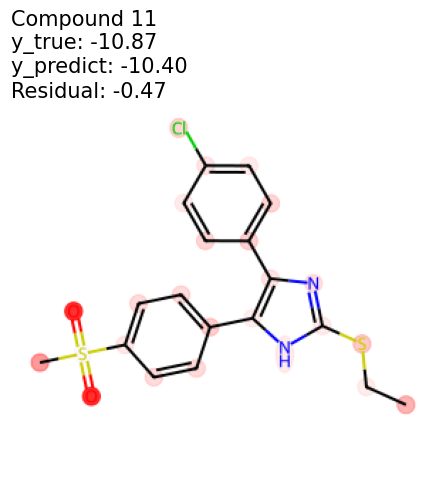

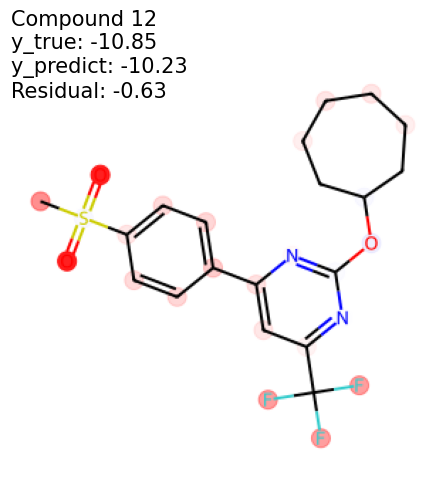

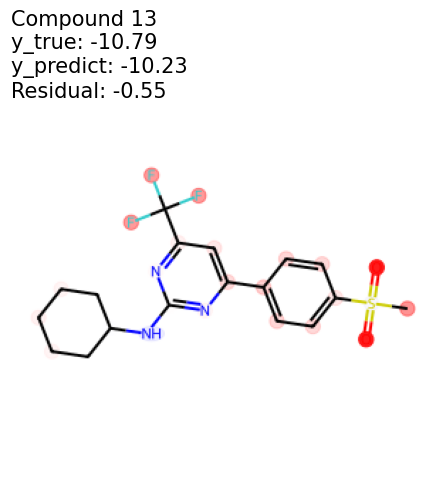

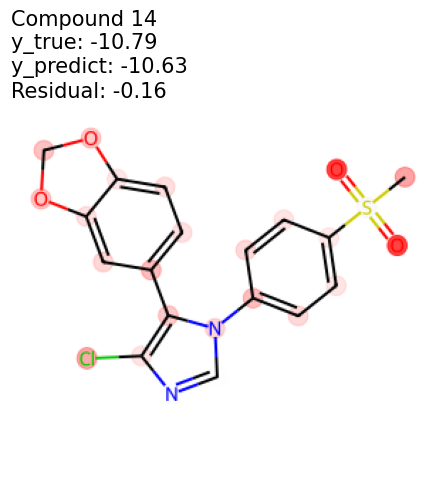

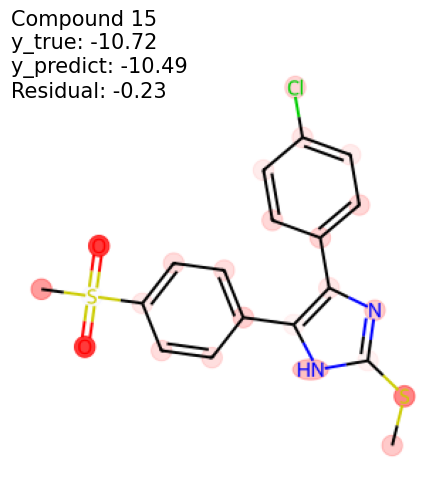

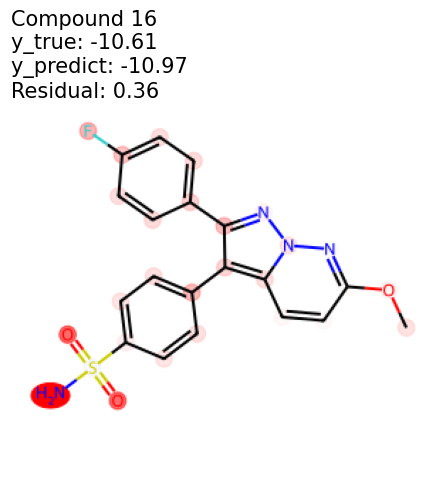

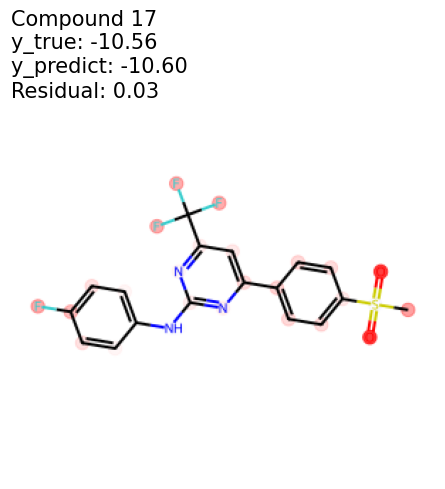

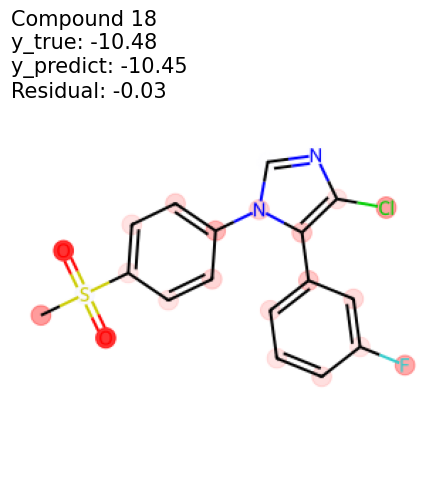

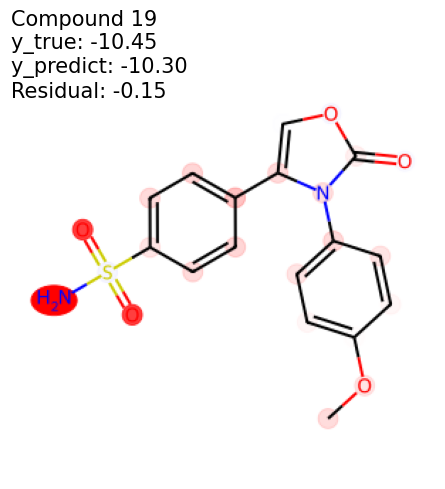

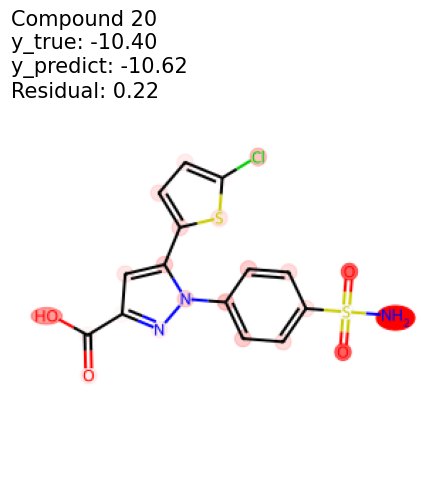

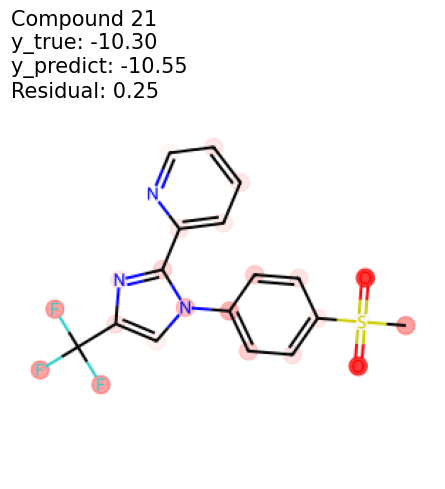

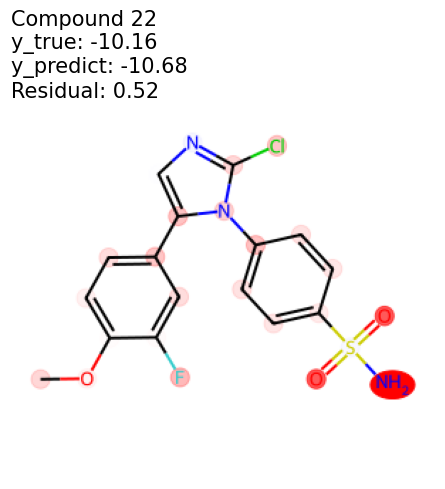

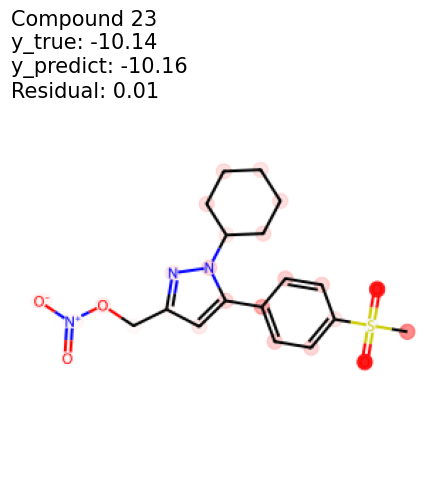

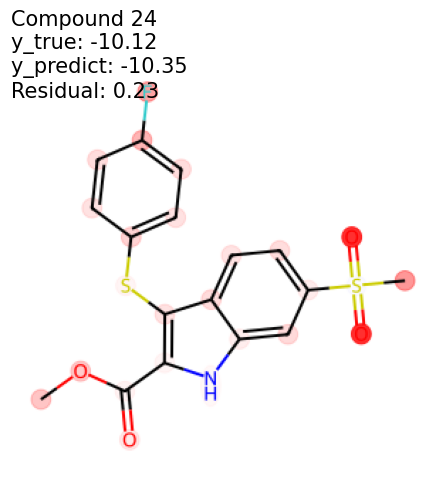

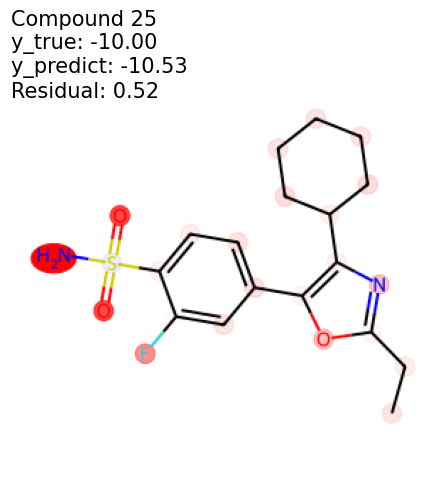

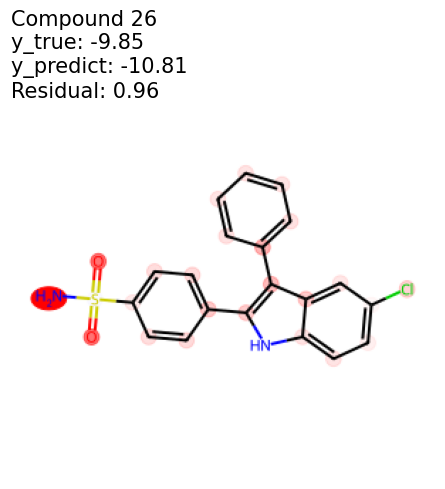

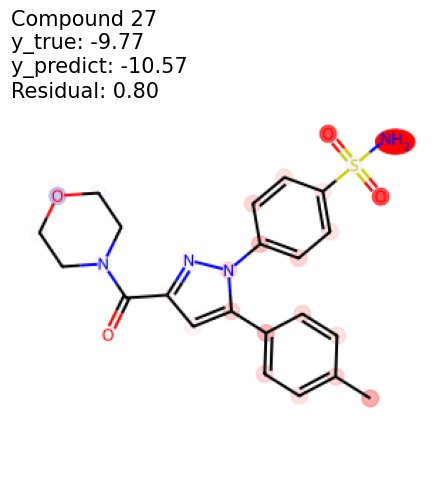

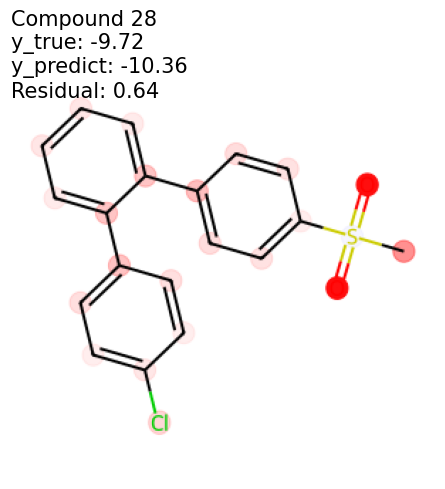

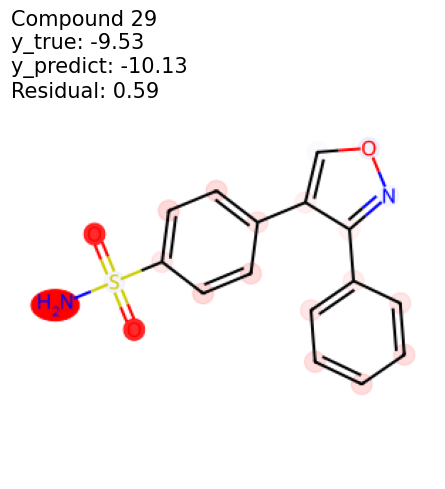

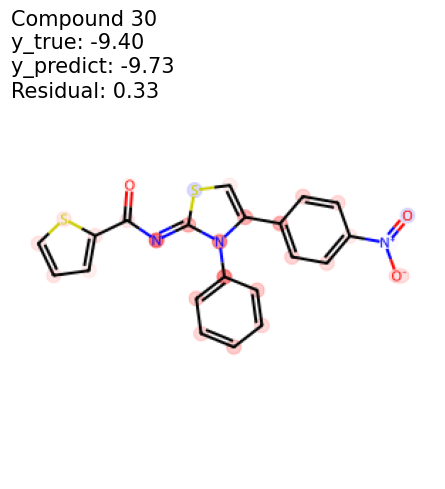

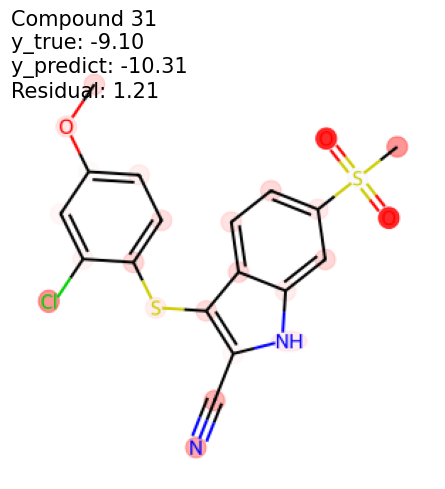

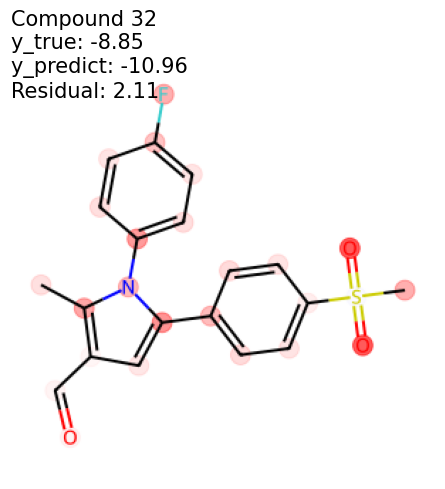

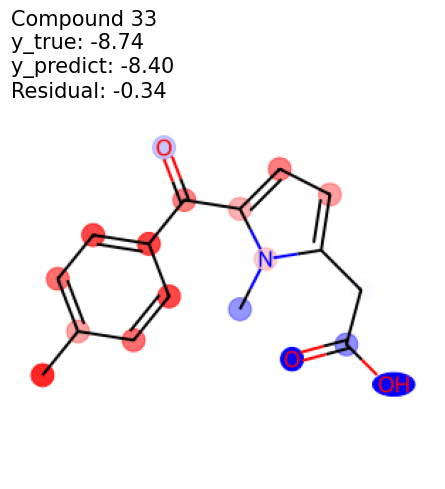

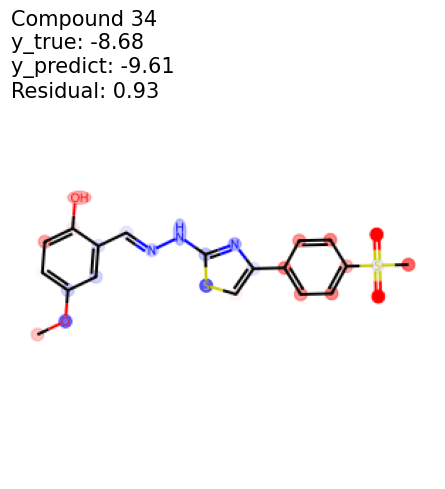

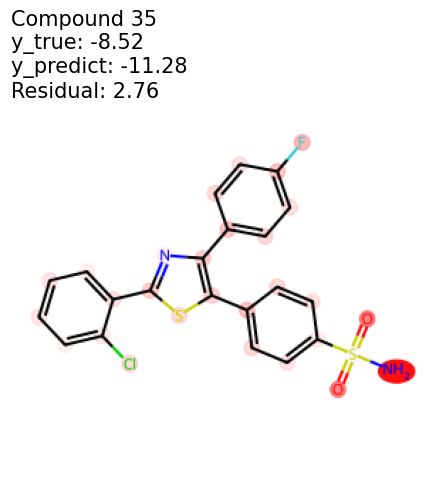

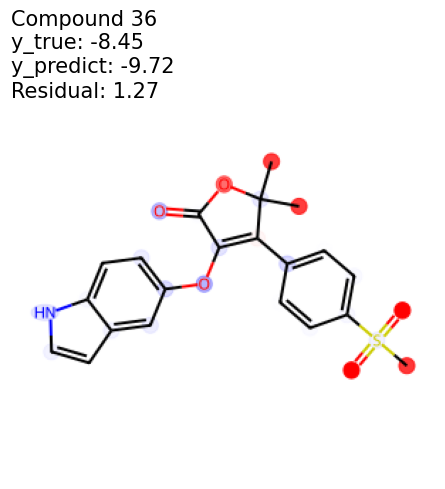

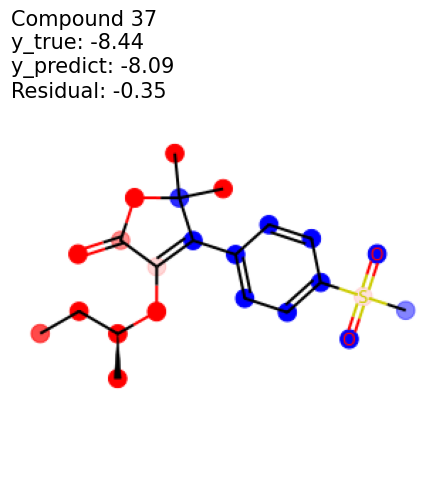

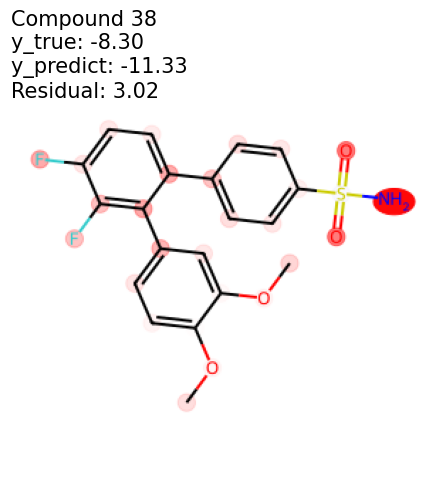

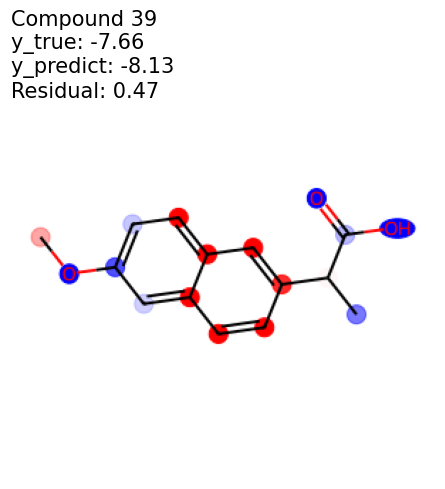

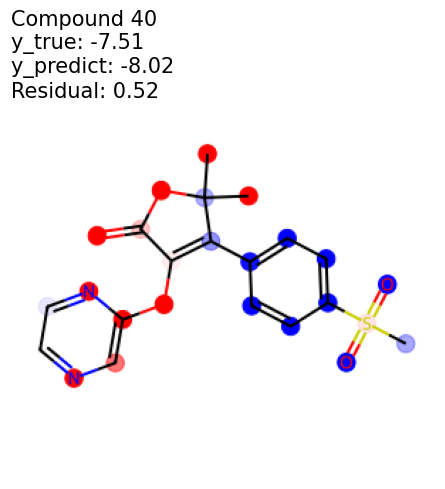

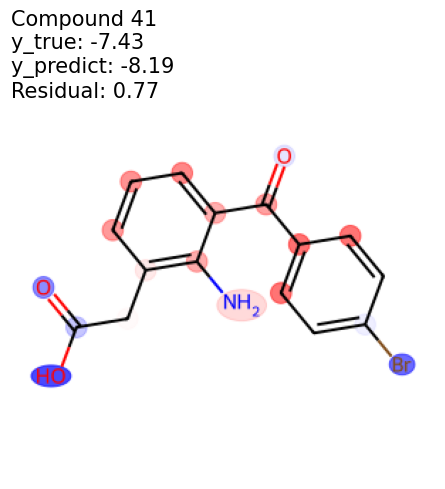

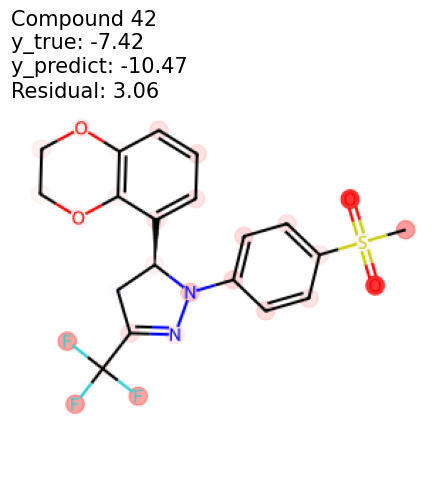

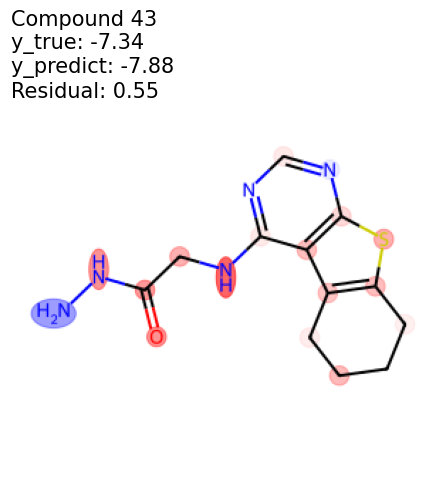

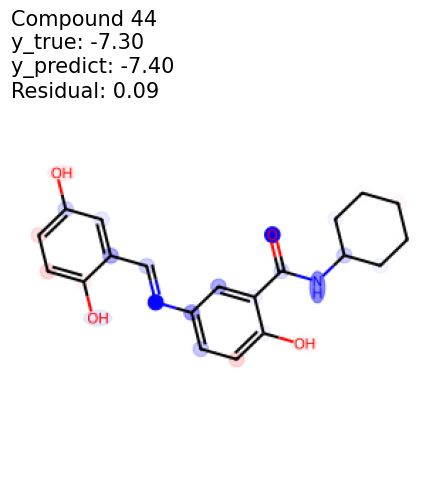

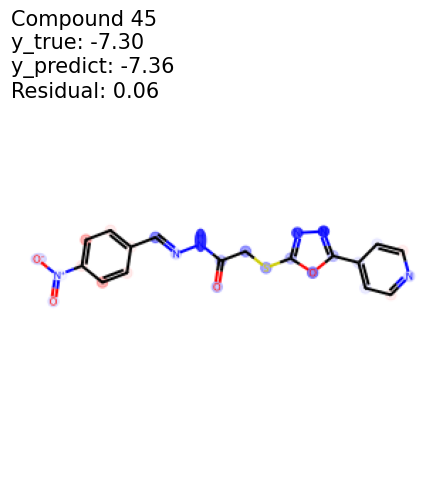

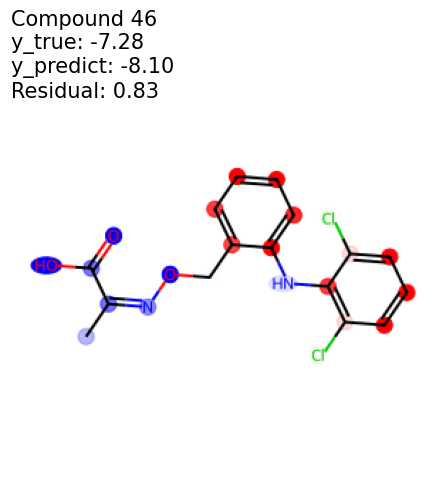

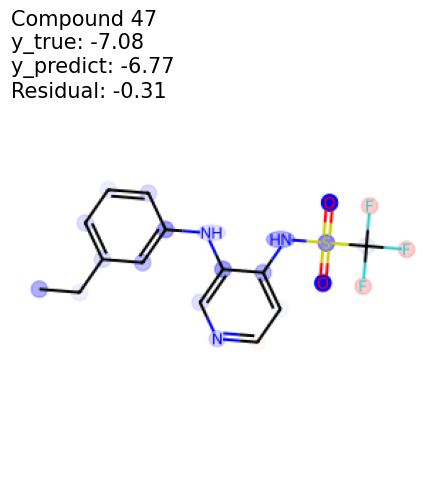

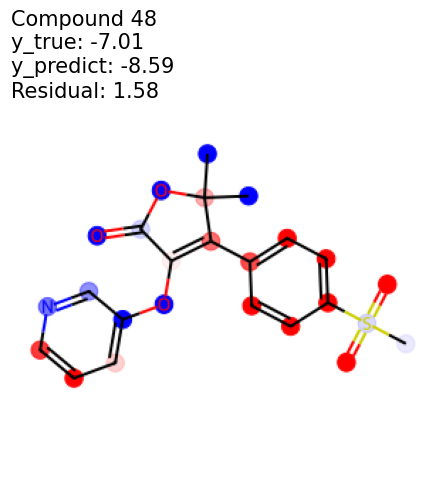

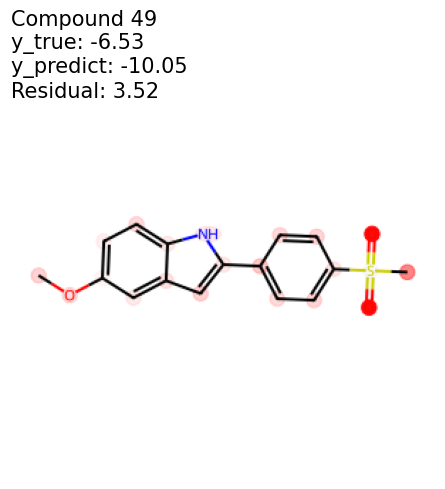

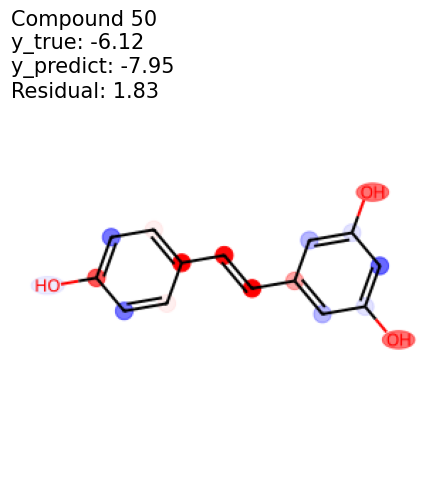

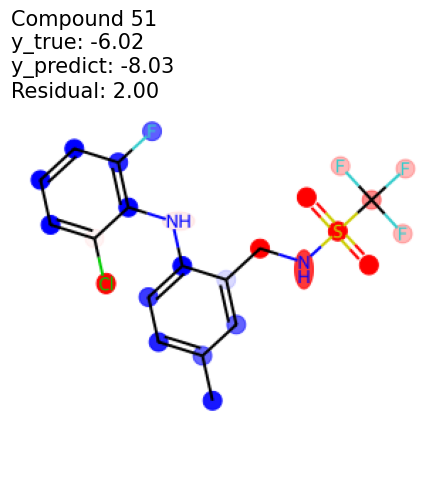

In [165]:
for compound_id in range(df_test.shape[0]):
    color_visualization(compound_id,dataset=test_dataset)
    score_visualization(compound_id)

# **9. Correctness analysis**
This part is project-dependent, because it requires the ground_truth explanations to evaluate correctness. For my project, the ground_truth explaination are determined for COX2 and CDK2 already. For the details of Correctness Evaluation Protocol, read the report.

For more details, please check https://github.com/DinhLongHuynh/lrp_chemprop/blob/main/lrp_chemprop/Correctness_Analyzer.py


In [18]:
quantile_width = 0.01
correctness = Correctness_Analyzer(relevance_score=relevance_atom_per_comp,ground_truth=ground_truth)
tau_avgs = correctness.quantile_analyzer(quantile_width=0.01)

(-0.01, 1.01)

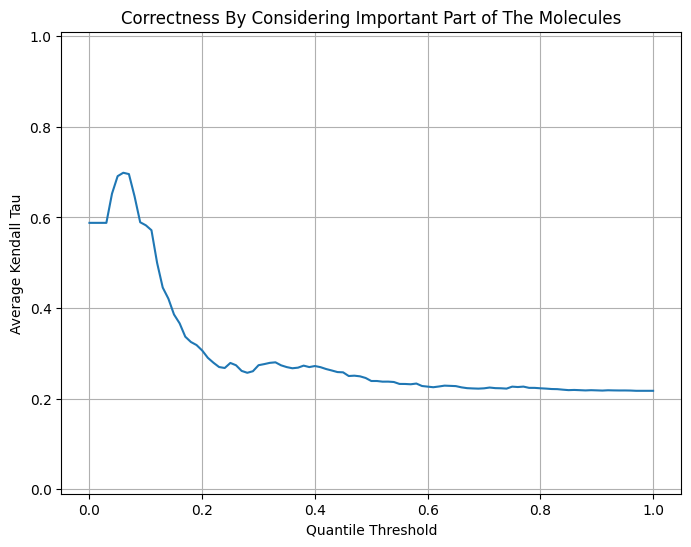

In [19]:
plt.figure(figsize=(8,6))
sns.lineplot(y=tau_avgs,x=np.arange(0,1 + quantile_width,quantile_width))
plt.title('Correctness By Considering Important Part of The Molecules')
plt.xlabel('Quantile Threshold')
plt.ylabel('Average Kendall Tau')
plt.grid()
plt.ylim(-0.01,1.01)

In [20]:
print("Correctness Reults")
print(f'AUC of Correctness Line: {np.trapezoid(tau_avgs,np.arange(0,1 + quantile_width,quantile_width))}')
print(f"Max Correctness: {tau_avgs.max()}")
print(f"Quatile of Max Correctness: {tau_avgs.argmax()*quantile_width}")
print(f"Last Correctness: {tau_avgs[-1]}")


Correctness Reults
AUC of Correctness Line: 0.29666548338620047
Max Correctness: 0.6986208538894458
Quatile of Max Correctness: 0.06
Last Correctness: 0.21721446391915933


# 9'. Correctness Analysis
This part do the similar task to 9, however with the consideration of each atom, instead of quantile.

In [21]:
num_atoms = 30
correctness = Correctness_Analyzer(relevance_score=relevance_atom_per_comp,ground_truth=ground_truth)
tau_avgs = correctness.atom_analyzer(num_atoms=30)

(-0.01, 1.01)

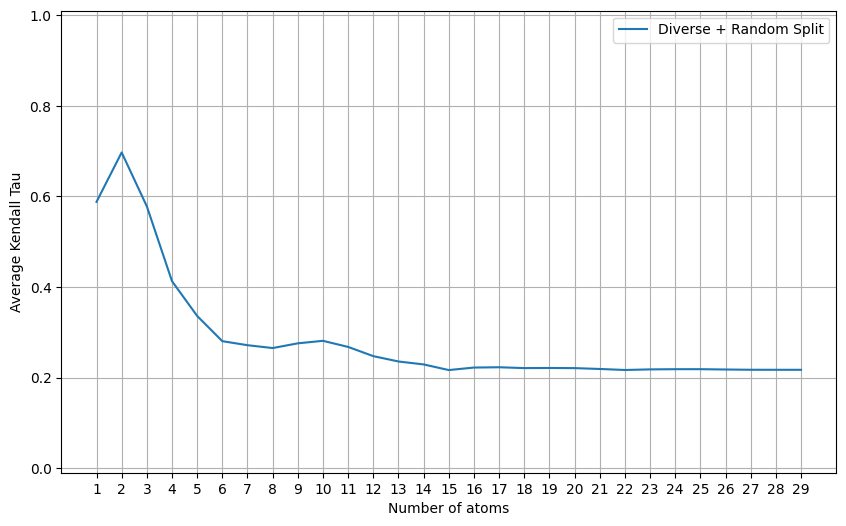

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(y=tau_avgs,x=np.arange(1,num_atoms),label='Diverse + Random Split')
plt.xticks(np.arange(1,30))
plt.xlabel('Number of atoms')
plt.ylabel('Average Kendall Tau')
plt.grid()
plt.ylim(-0.01,1.01)

In [24]:
print("Correctness Reults")
print(f'AUC of Correctness Line: {np.trapezoid(tau_avgs,np.arange(1,num_atoms)/(num_atoms-2))}')
print(f"Max Correctness: {tau_avgs.max()}")
print(f"Num_atom of Max Correctness: {tau_avgs.argmax()+1}")
print(f"Last Correctness: {tau_avgs[-1]}")


Correctness Reults
AUC of Correctness Line: 0.28033554864769616
Max Correctness: 0.6970870818033205
Num_atom of Max Correctness: 2
Last Correctness: 0.21721446391915933
